# To apply or to applymap, that is the question


In [1]:
import pandas as pd
import numpy as np

import random
import string

import timeit
import gc

from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

Assume you have a pandas dataframe where every entry is a strings and you want to turn all of the entries of the dataframe into lower case. There are multiple ways you can accomplish this, the question is which one is faster. Without going through the implementations of each method and understanding how they work, how much of parallelization is there and how well is it used, you can just get a sense of how each method performs on your machine, simply by running it multiple times. 

# Setup

The data can vary in a few ways, for simplicity I'm going to assume all of the strings in all of the entries are of a fixed length, and they contain only lower and upper case english letters and space, though this shouldn't really matter. This means I can generate a random string of a given length easily this way:

In [2]:
def random_string_generator(str_len):
    """generate random strings"""
    allowed_chars = string.ascii_letters + ' ' # + string.punctuations
    return ''.join(random.choice(allowed_chars) for x in range(str_len))

Here is an example

In [3]:
random_string_generator(str_len = 100)

'cwGoXtKmcWBNRBCFWzvcebNVOGAvBczGOLwftwgrPuCnogxgXYzMSRpPqsxLarmWccKaQJhUDXrKcBcWQTNHpfzoVyvNjVCOoZOv'

The data frame now only depends on how many rows and columns it has and the length of the string. So I can generate one of a fixed size this way:

In [4]:
def random_str_df(df_shape, str_len):
    df = pd.DataFrame(
        np.array(
            [
                [
                    random_string_generator(str_len) for i in range(df_shape[1])
                ] for j in range(df_shape[0])
            ]
        )
    )
    return df

In [5]:
random_str_df(df_shape = [5, 2], str_len = 3)

0    1
0  XGt  DQz
1  Bce  ztz
2  CES  OHr
3  pPu  tbW
4  HqD  MTa

And here is a helper function that will sort a particular part of the dataframe of the recorded times

In [6]:
def sort_by_times(df, cols, grouping):
    sdf = df[
        np.sum(
            df[cols] == grouping, 
            axis = 1
        ) == len(cols)
    ].groupby('function').agg({'times': ['sum', 'std']})\
    .sort_values([('times', 'sum')], ascending = False)\
    .reset_index()
    return sdf 

Now I can turn all those into a lower case strings in various ways. Here are some that come to my mind:
1. use apply with lambda method to each column and loop over columns
2. use apply with str.lower method to each col and loop over columns
3. use applymap with lambda method to the whole dataframe
4. use applymap with str.lower to the the whole dataframe
5. use numpy.vectorize with lampda method to the whole dataframe (I'm not looping over columns because I'm sure it's not gonna be better than this one! But I think I could test that too)
6. use a nested for loop over all entries of the dataframe

Notes: 
- In applying these methods I'm not writing to a new nor the original dataframe. That is a separate issue that can be discussed. For example, looping might see a significant increase in time when writing. That's an idea for another simulation.
- I am assuming the number of columns is generally much smaller than the number of rows, if it's the other way around, there are better ways to handle this, if both are huge, then we should compare the methods, though if a row method or a column method is better, then we can just transpose lowercase everything and transpose again.

In [7]:
def apply_lambda_lower(df):
    for col in df.columns:
        df[col].apply(lambda x: x.lower())
        
def apply_str_lower(df):
    for col in df.columns:
        df[col].apply(str.lower)
        
def applymap_lambda_lower(df):
    df.applymap(lambda x: x.lower())

def applymap_str_lower(df):
    df.applymap(str.lower)
    
def np_vectorize_lambda_lower(df):
    np.vectorize(lambda x: x.lower())(df)
    
def entrywise_lower(df):
    (m, n) = df.shape
    for i in range(m):
        for j in range(n):
            df.at[i,j].lower()

# Simulate

here I'm defining a grid of parameters to test over them.

In [8]:
functions = [
    'apply_lambda_lower',
    'apply_str_lower',
    'applymap_lambda_lower',
    'applymap_str_lower',
    'np_vectorize_lambda_lower',
    'entrywise_lower',    
]
str_lens = [1, 8, 16, 32]
rows = [1, 100, 10000, 1000000]
columns = [1, 2, 3, 5, 10, 20, 30]
repeats = [1000]

Distinctions and expectations:
- The str_len = 1 is working as a baseline so to minimize the difference between str.lower() and ''.lower() calls.
- The rows = 1 helps to identify the overhead of each of the methods, I'm guessing the dataframe methods have the largest overhead, the loops over the columns have slightly less overhead, and the nested loop has the lowest one.
- The columns = 1 works to identify the differences between the dataframe methods and the loop over column methods, if they do the same thing under the hood, they should perform the same in this case.
- repeats is just how many times I want to repeat to get a confidence interval. At the end I didn't really bother to dig deep into it since the differences were very clear.

And finally let's run this:
- for each combination of rows, columns, and sting length I generate a new dataframe, and I run all functions on the same dataframe a 1000 times. I record all the run times and I'll later use that to analyse it

In [9]:
# times_df = pd.DataFrame()
# for row, col, str_len, repeat in product(rows, columns, str_lens, repeats):
#     print(row, col, str_len, repeat, '\r', end = "")
#     df = df = random_str_df(
#         str_len = str_len,
#         df_shape = (row, col)
#     )
#     for fun in functions:
#         times = timeit.repeat(
#             stmt = fun + '(df)',
#             setup = 'gc.enable()',
#             number = 1,
#             repeat = repeat,
#             globals = globals()
#         )
#         tdf = pd.DataFrame({
#             'function': fun,
#             'rows': row, 
#             'columns': col, 
#             'str_len': str_len,
#             'repeat': repeat,
#             'times': times, 
#         })
#         times_df = times_df.append(tdf, ignore_index = True)
#         times_df.to_csv('times.csv', index = False)

For the 1M row case it was taking forever to run on my machine, so I just stopped it. I think I have enough cases to make a decision.

# Plot

OK, let's look at some pretty pictures to see how each case is performing. I'll plot everything first, and then try to dig deeper in some more intertseting cases. 
- Seaborn is taking care of the confidence intervals (the default is 95% and I used that).
- Times are in seconds
- It turns out the string length didn't really matter that much. So, for the sake of less graphs to look at, I pull all of them together

The hard question is how to visualize so many parameters. Since we usually have a fixed dataframe it makes sense to look at each size dataframe separately and then try to summarize things. This is what I'm going to do here.

In [69]:
times_df = pd.read_csv('times.csv')

In [11]:
def barplot_functions(df):
    fig = plt.figure(figsize = [8,3])
    sns.barplot(
        data = gdf,
        x = 'function',
        y = 'times'
    )
    plt.xticks(rotation = -90)
    plt.ylabel('time (s)')
    plt.yscale('log')
    plt.gca().get_yaxis().grid()
    return(fig)

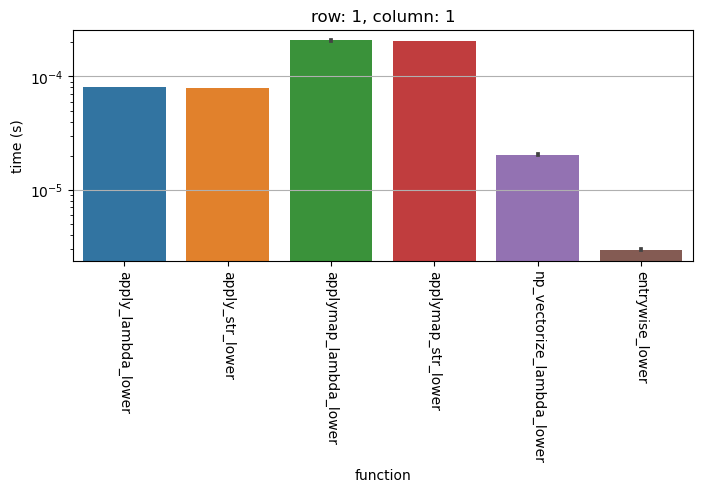

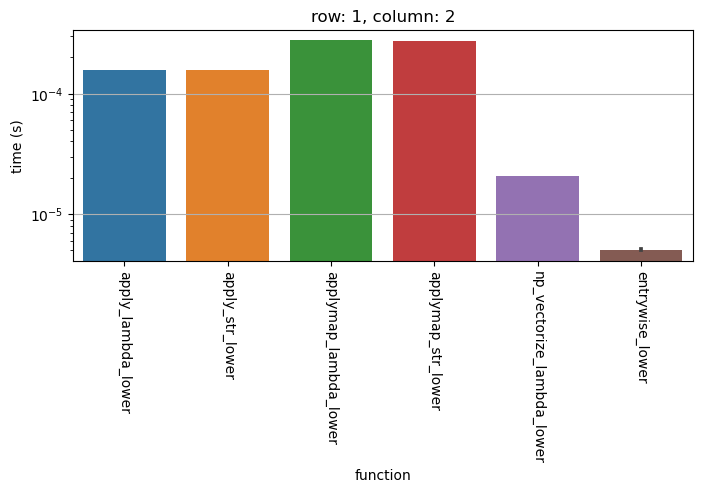

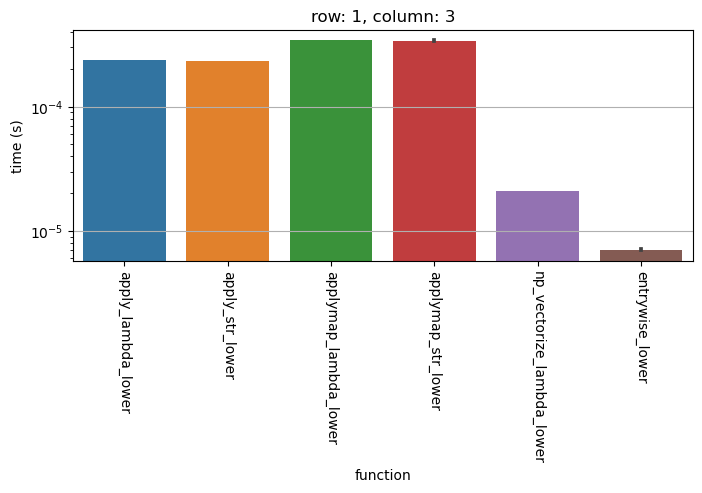

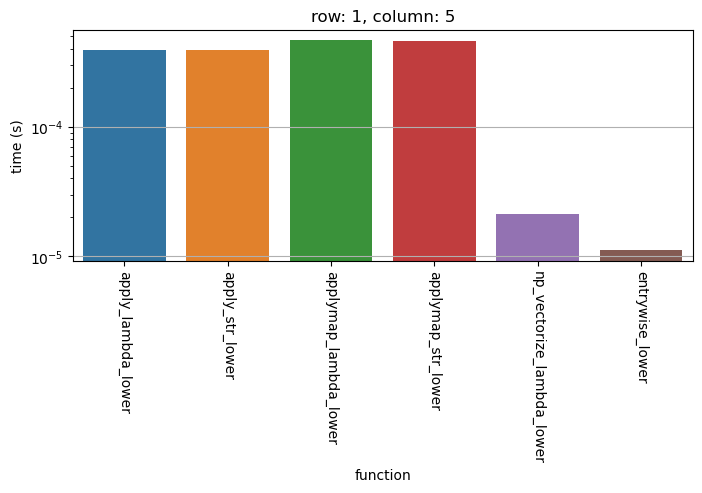

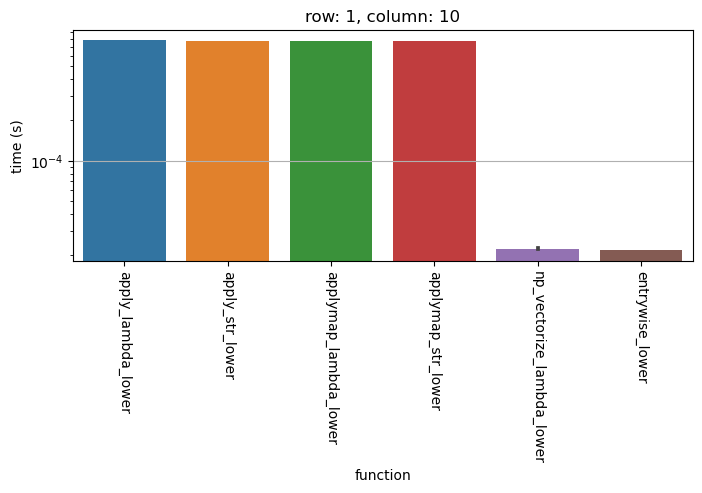

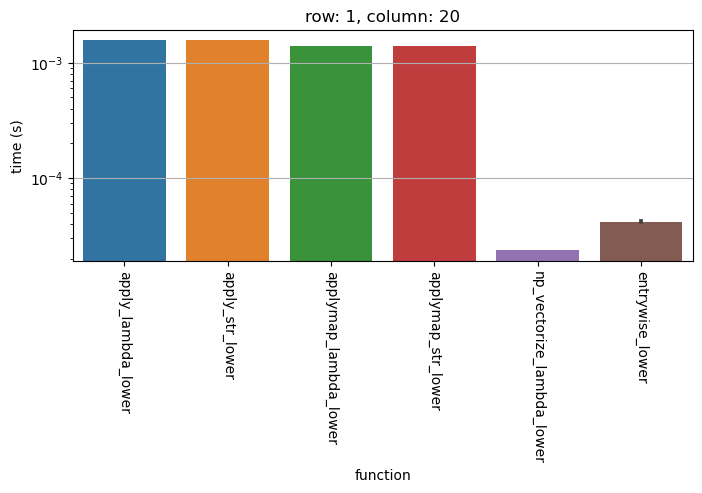

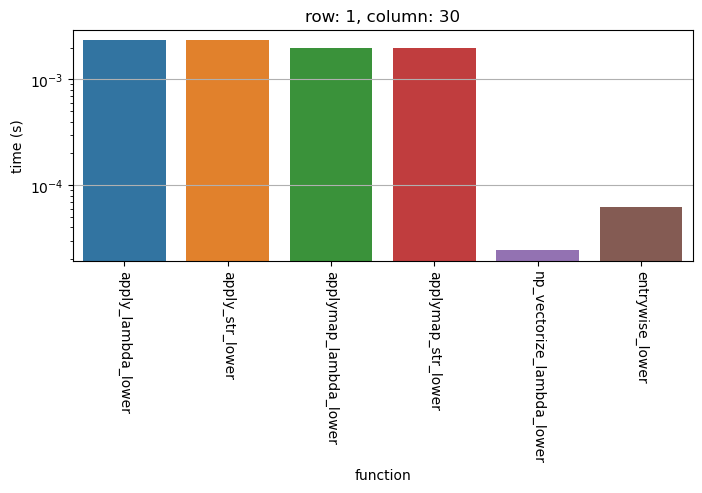

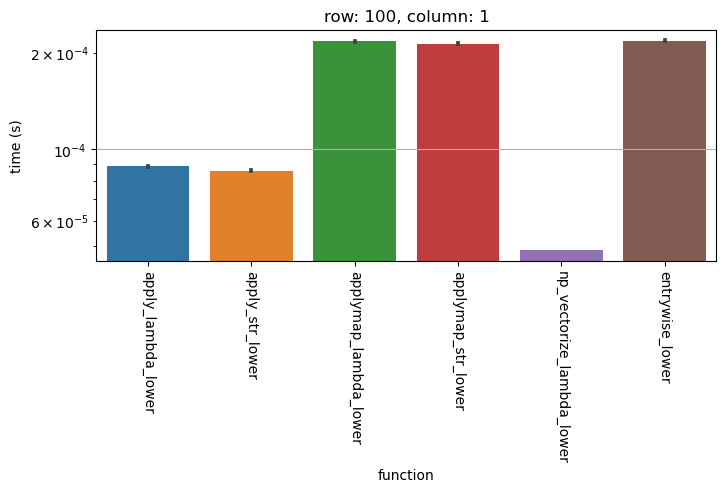

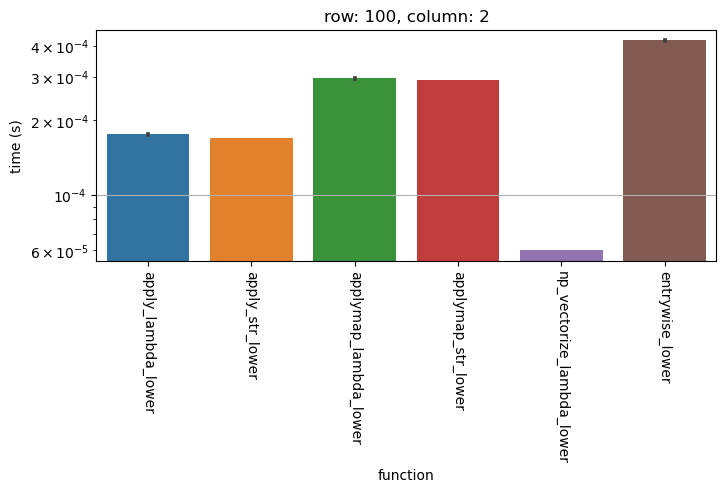

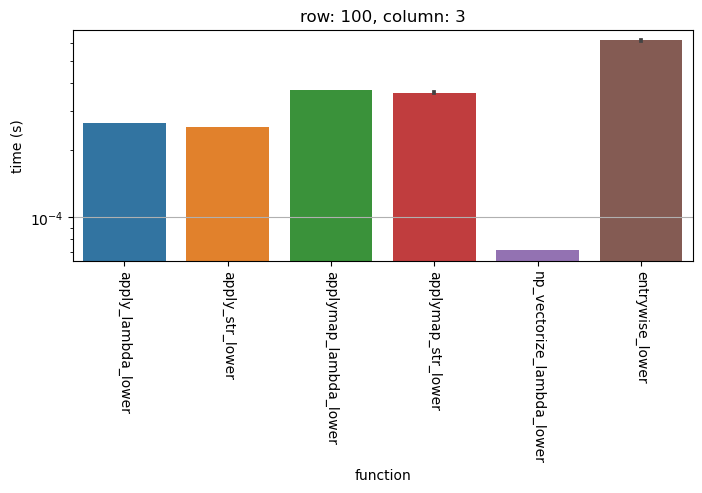

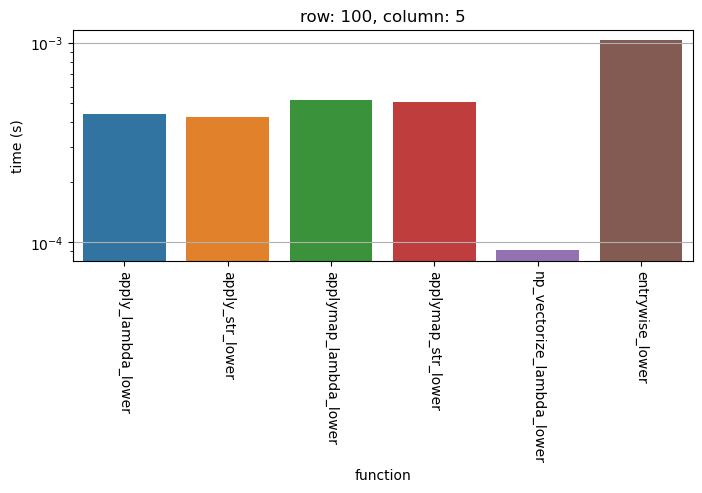

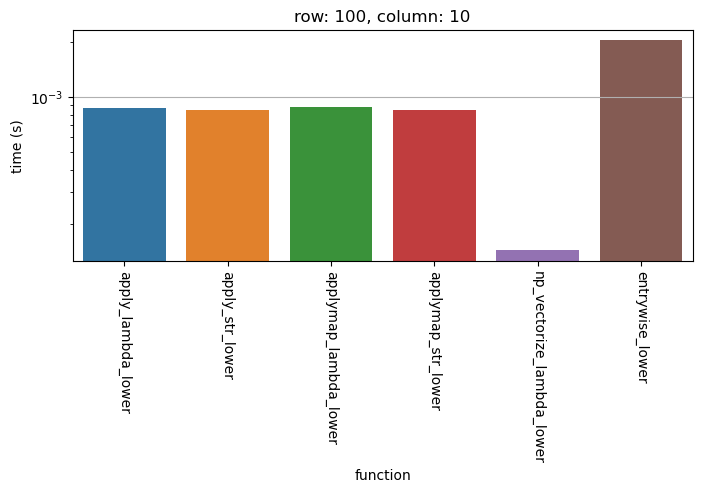

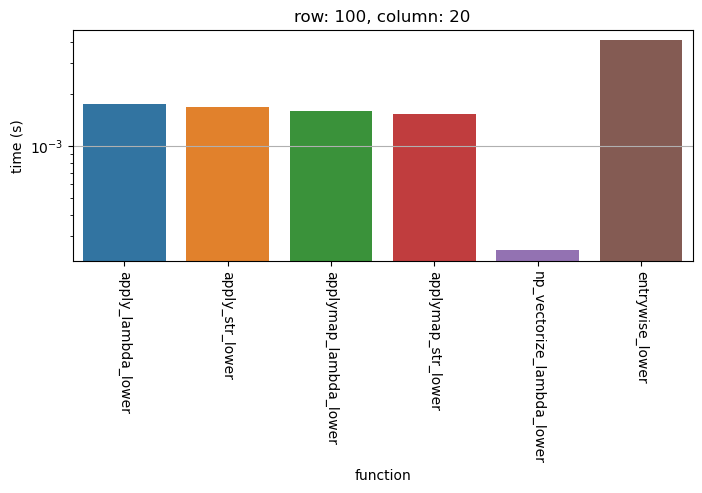

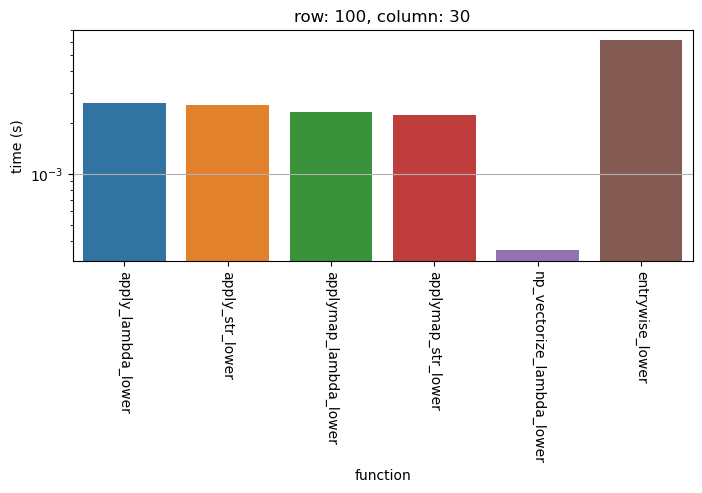

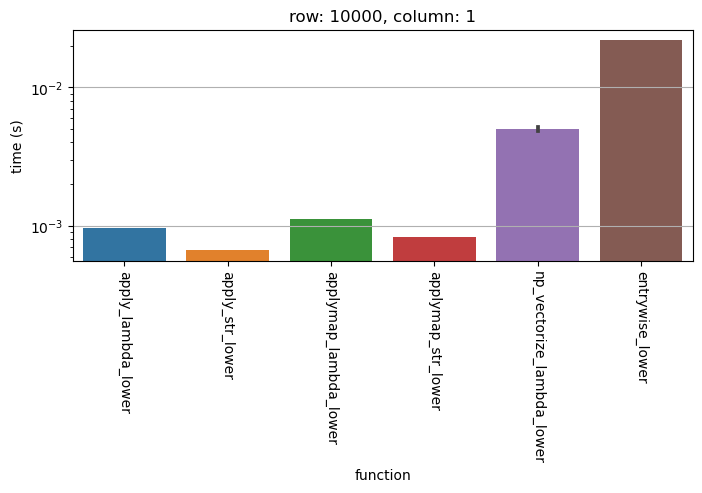

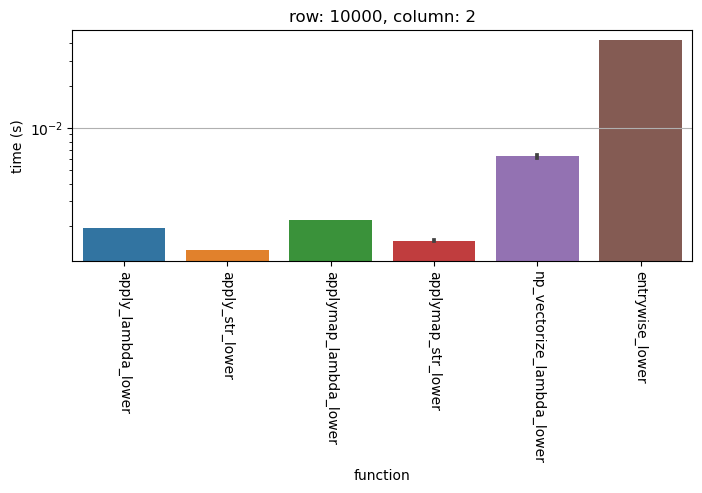

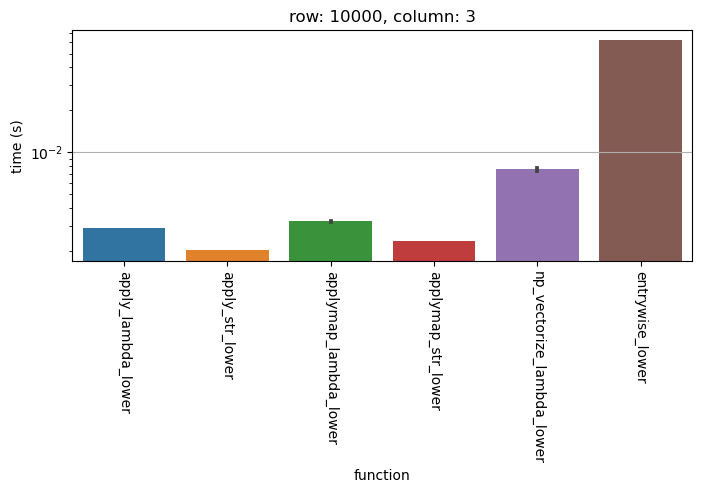

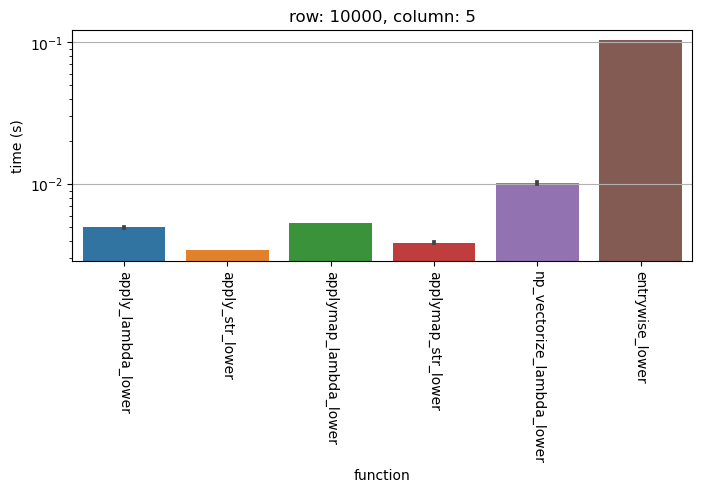

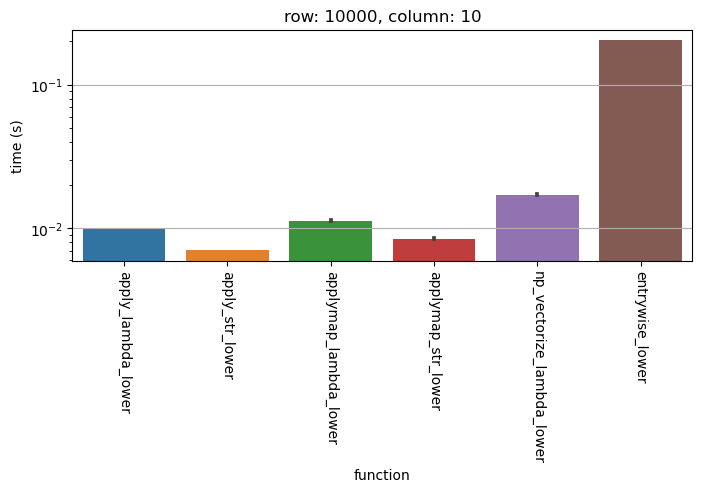

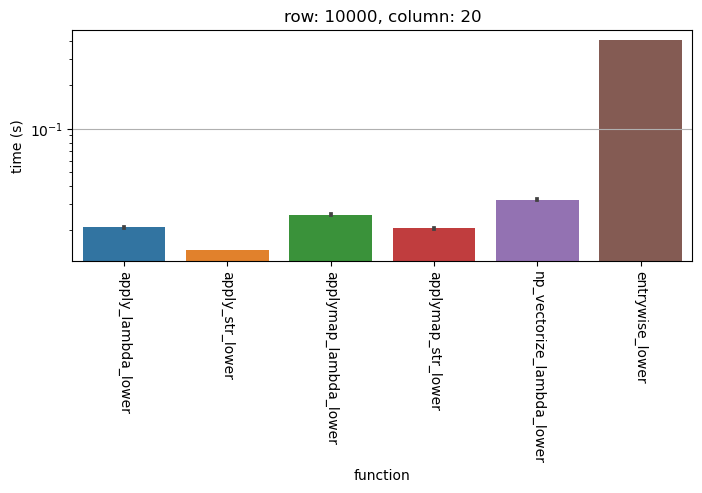

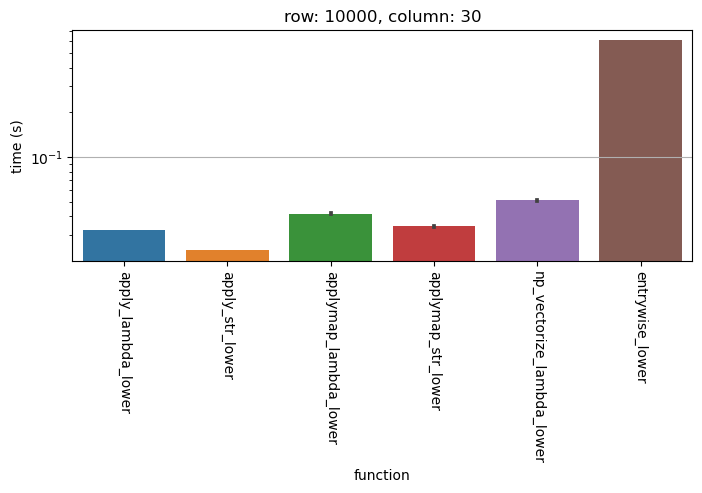

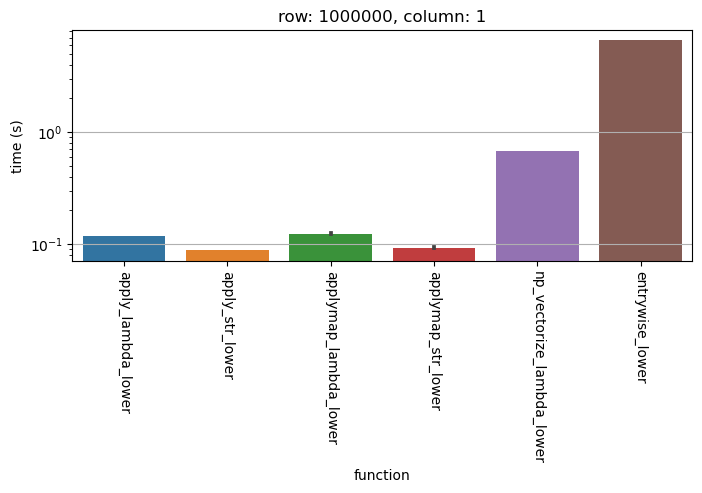

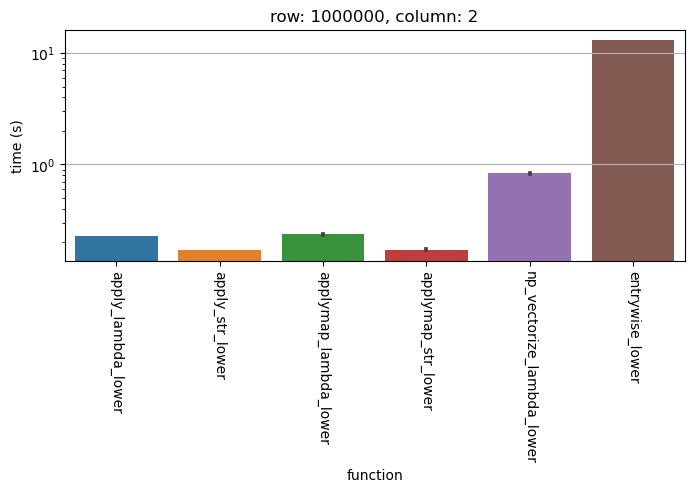

In [12]:
barplots = {}
for gp, gdf in times_df.groupby(['rows', 'columns']):
    barplots[gp] = barplot_functions(gdf)
    plt.title('row: {}, column: {}'.format(gp[0], gp[1]))
    plt.show()

Observations:
- the first plot shows the overheads, as we expected
    - applymap has the largest overhead with 
    - then there are apply methods
    - numpy.vectorize has a quarter of overhead compared to the apply (I didn't have any expectations here)
    - nested for loop is the winner.

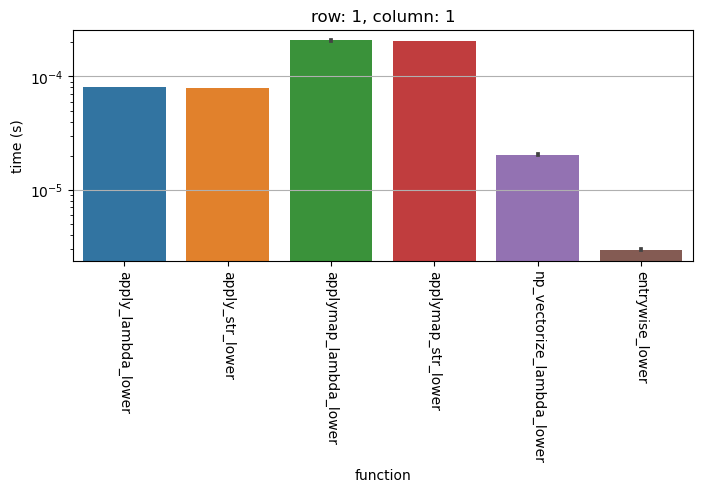

In [13]:
barplots[(1, 1)]

here are the numbers for comparison

In [14]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [1, 1])

function     times          
                                   sum       std
0      applymap_lambda_lower  0.830499  0.000014
1         applymap_str_lower  0.819814  0.000005
2         apply_lambda_lower  0.321640  0.000011
3            apply_str_lower  0.315734  0.000003
4  np_vectorize_lambda_lower  0.081966  0.000001
5            entrywise_lower  0.011884  0.000001

Slowly increasing the number of the columns the overall picture doesn't change much, means still everything is based on the overheads. However, when keeping rows = 1, by the time that we get to 10 columns we can see that apply and applymap are perfoming quite similarly,1 that kind of sets expectations about how we can see the for loop on apply method is slowing us down. And now numpy.vectorize and nested for loop are performing similar to each other.

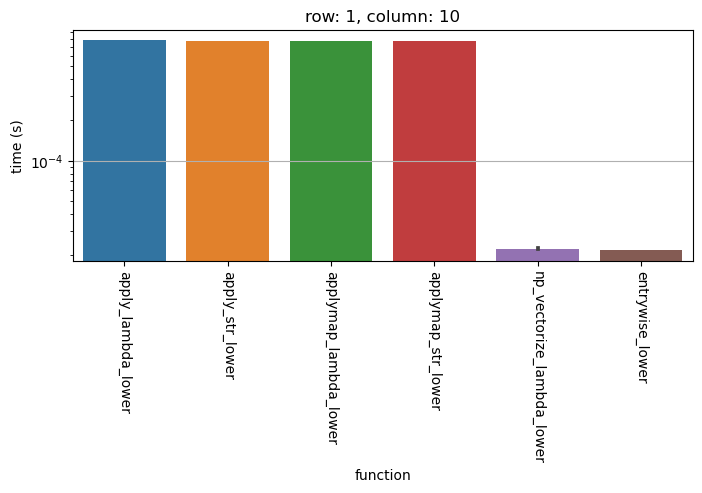

In [15]:
barplots[(1, 10)]

In [16]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [1, 10])

function     times          
                                   sum       std
0         apply_lambda_lower  3.124020  0.000019
1            apply_str_lower  3.115929  0.000014
2      applymap_lambda_lower  3.097989  0.000019
3         applymap_str_lower  3.088293  0.000018
4  np_vectorize_lambda_lower  0.088607  0.000003
5            entrywise_lower  0.086423  0.000003

And finally, by the time we are in 20 columns that we can see the performances have changed. No longer the nested loop is the best performing method and the numpy.vectorize takes over.

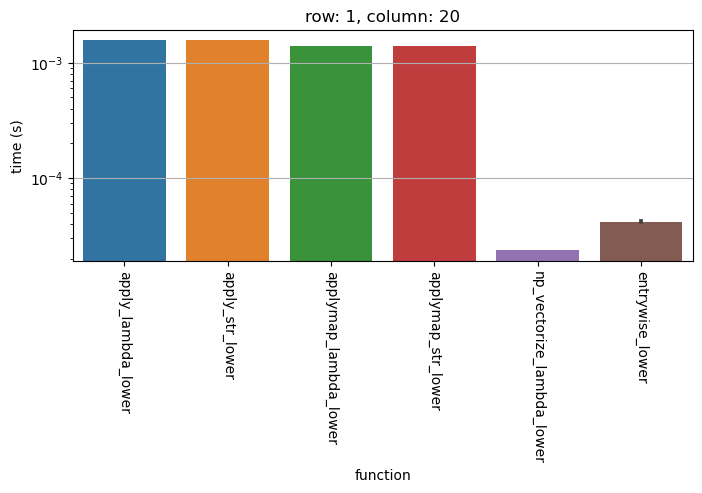

In [17]:
barplots[(1, 20)]

In [18]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [1, 20])

function     times          
                                   sum       std
0         apply_lambda_lower  6.245121  0.000027
1            apply_str_lower  6.239150  0.000016
2      applymap_lambda_lower  5.558962  0.000028
3         applymap_str_lower  5.543641  0.000024
4            entrywise_lower  0.167147  0.000004
5  np_vectorize_lambda_lower  0.094646  0.000004

As soon as we have more than 1 row (here 100 rows) we see there is a difference. applymap is still slower than apply. This makes sense since we do expect a larger overhead for the dataframe method and here we only have one column so far. and we are already seeing how badly the nested loop is performing.

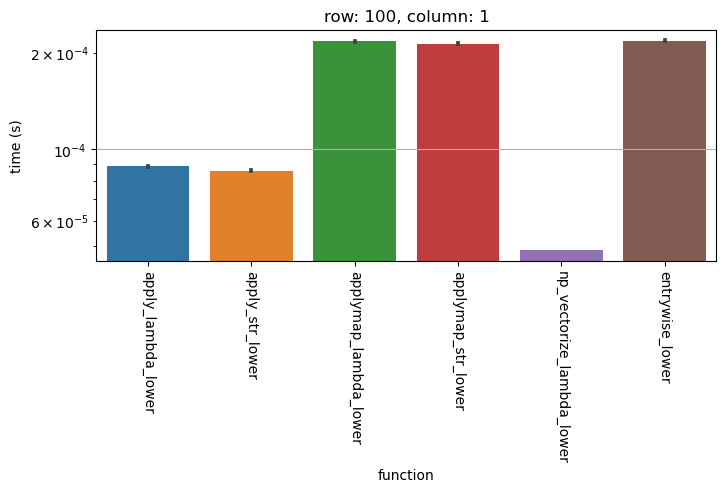

In [19]:
barplots[(100, 1)]

In [20]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [100, 1])

function     times          
                                   sum       std
0            entrywise_lower  0.872495  0.000008
1      applymap_lambda_lower  0.866736  0.000013
2         applymap_str_lower  0.853855  0.000011
3         apply_lambda_lower  0.354346  0.000011
4            apply_str_lower  0.343194  0.000007
5  np_vectorize_lambda_lower  0.194616  0.000005

with 10 columns apply and applymap start performing the same, and after that applymap is doing better. This means the implementation there is better than a for loop.

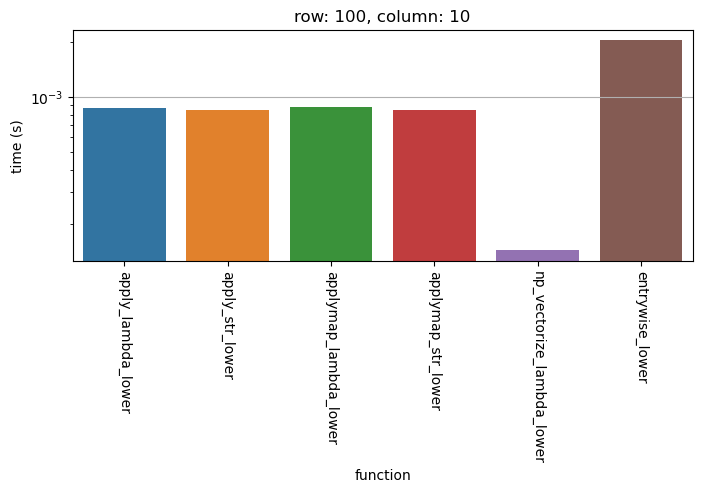

In [21]:
barplots[(100, 10)]

In [22]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [100, 10])

function     times          
                                   sum       std
0            entrywise_lower  8.164509  0.000034
1      applymap_lambda_lower  3.504533  0.000029
2         apply_lambda_lower  3.494702  0.000018
3            apply_str_lower  3.377405  0.000023
4         applymap_str_lower  3.375017  0.000026
5  np_vectorize_lambda_lower  0.578627  0.000012

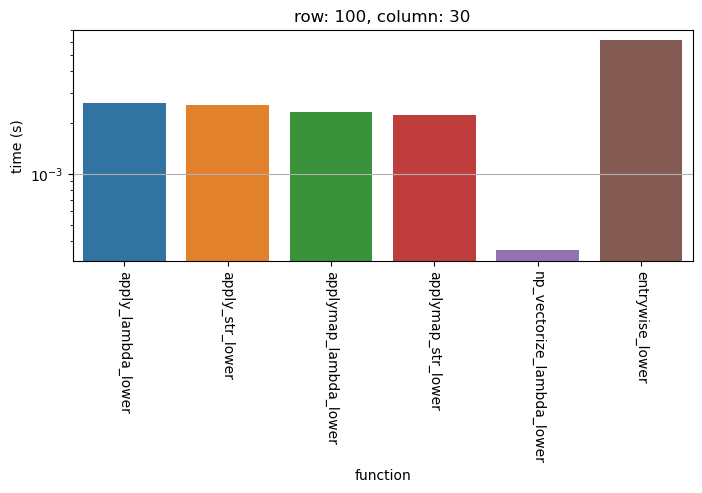

In [23]:
barplots[(100, 30)]

In [24]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [100, 30])

function      times          
                                    sum       std
0            entrywise_lower  24.402314  0.000066
1         apply_lambda_lower  10.479677  0.000032
2            apply_str_lower  10.132349  0.000033
3      applymap_lambda_lower   9.207793  0.000044
4         applymap_str_lower   8.850208  0.000043
5  np_vectorize_lambda_lower   1.417060  0.000031

The case 10K rows and 1 column starts to become more like a real case. Here we see the real differences where everything changes. 
- The apply is better than applymap, again hinting at less overhead. 
- Also, the interesting difference now comes with the str.lower performing much better than the lambda method in both cases. 
- And numpy.vectorize starts to be very bad now.

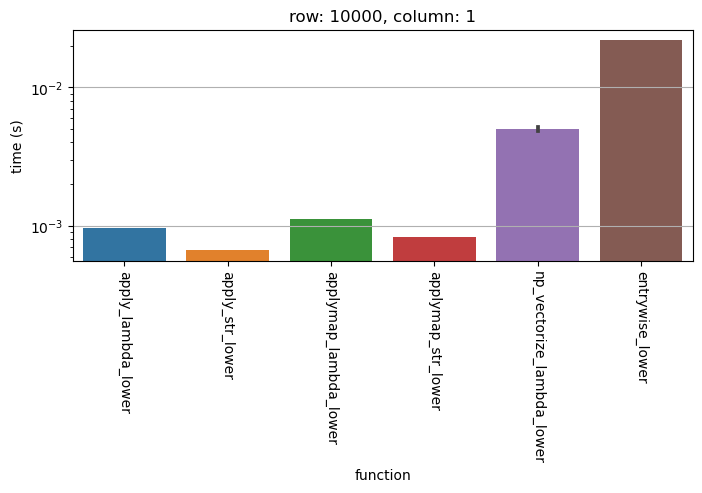

In [25]:
barplots[(10000, 1)]

In [26]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [10000, 1])

function      times          
                                    sum       std
0            entrywise_lower  87.243579  0.000219
1  np_vectorize_lambda_lower  20.029896  0.005749
2      applymap_lambda_lower   4.494563  0.000084
3         apply_lambda_lower   3.838573  0.000077
4         applymap_str_lower   3.306172  0.000081
5            apply_str_lower   2.671375  0.000076

One surprising observation is that with up to 30 columns in 10K rows the applymap didn't catch up with the apply method. I'll have to see if it will ever, or if there is a trend that I hope that it will. If not, that's gonna be an intersting result. Similar thing holds for 1M rows, except I didn't run it for more than 2 columns.

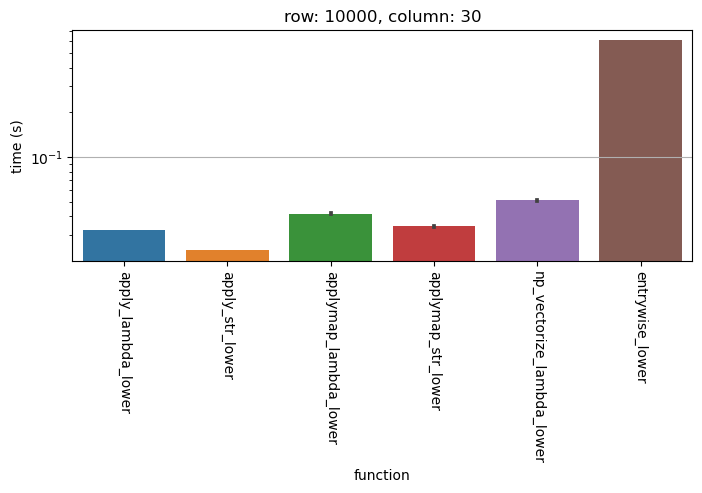

In [27]:
barplots[(10000, 30)]

In [28]:
sort_by_times(df = times_df, cols = ['rows', 'columns'], grouping = [10000, 30])

function        times          
                                      sum       std
0            entrywise_lower  2439.571425  0.004545
1  np_vectorize_lambda_lower   204.804382  0.012319
2      applymap_lambda_lower   166.522401  0.007986
3         applymap_str_lower   137.306918  0.007936
4         apply_lambda_lower   129.982123  0.003847
5            apply_str_lower    95.011932  0.004614

# Trends

So far this is fun and informative, but let's look at the trends and see if we can figure out some more stuff by pretending we are good at seeing patterns.

I have three variables that I am intersted in: rows, columns, and str_len. I've said before that str_len is not that important, here let's see why I think so, and how correct I was. Then I'll look at the how increaing rows and columns will affect the performance times.

In [46]:
sns.lineplot?

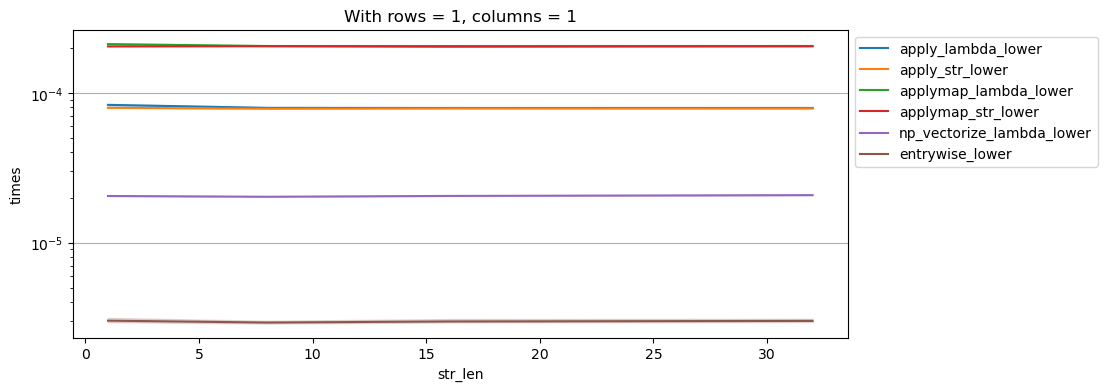

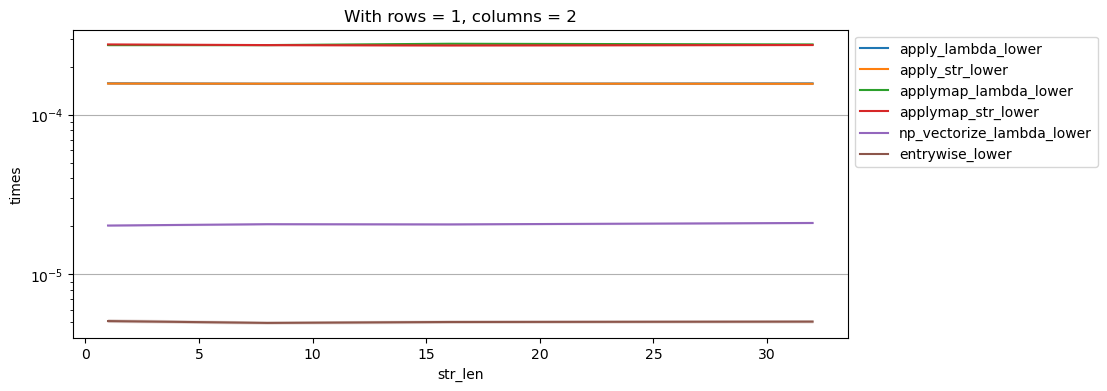

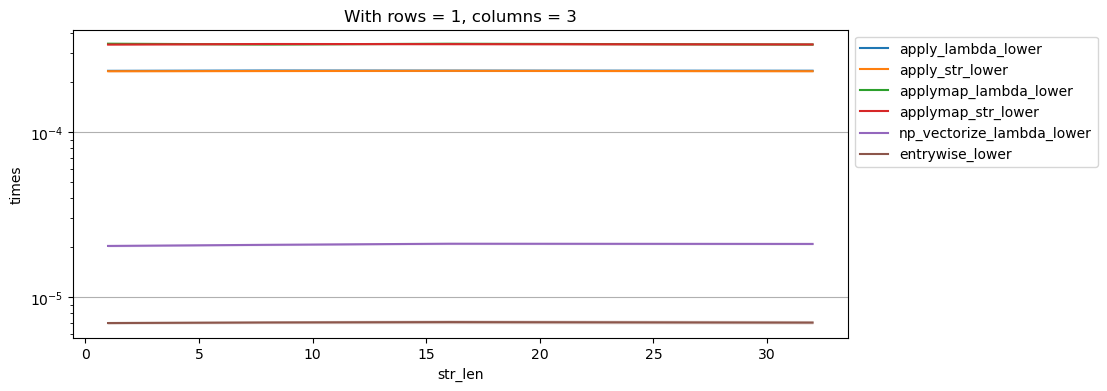

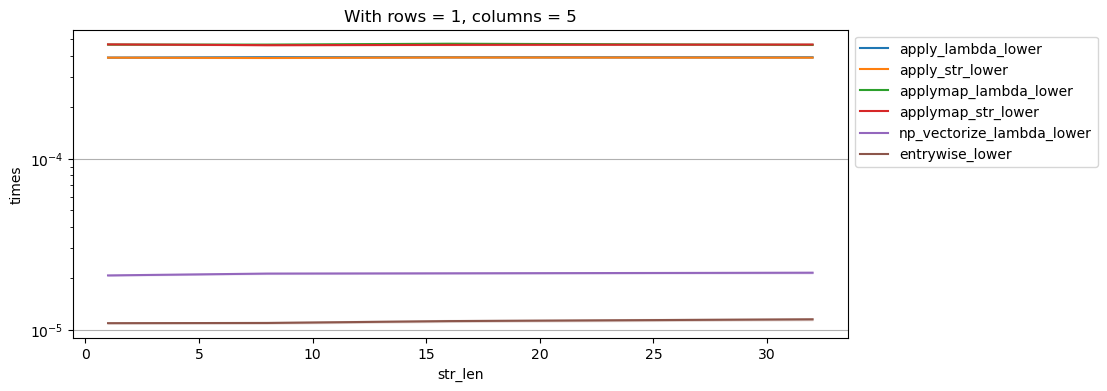

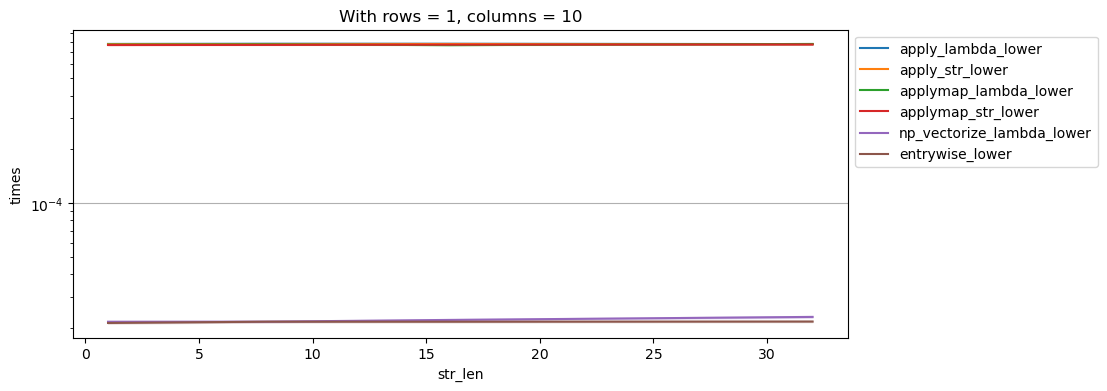

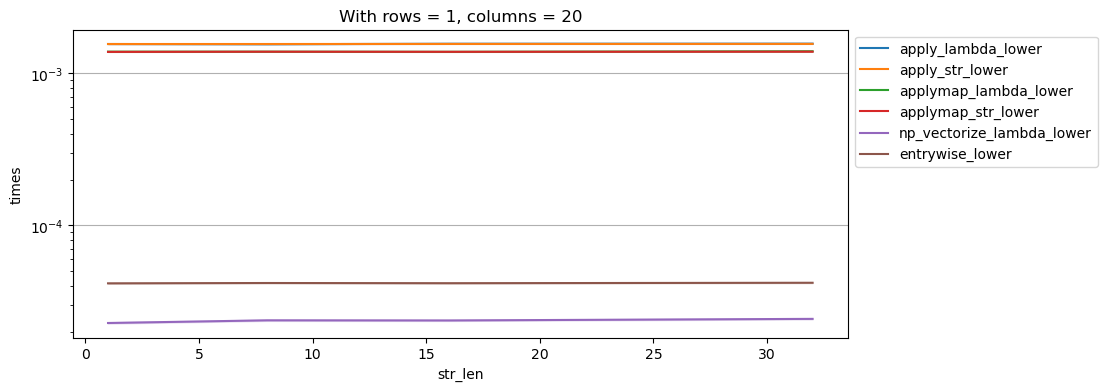

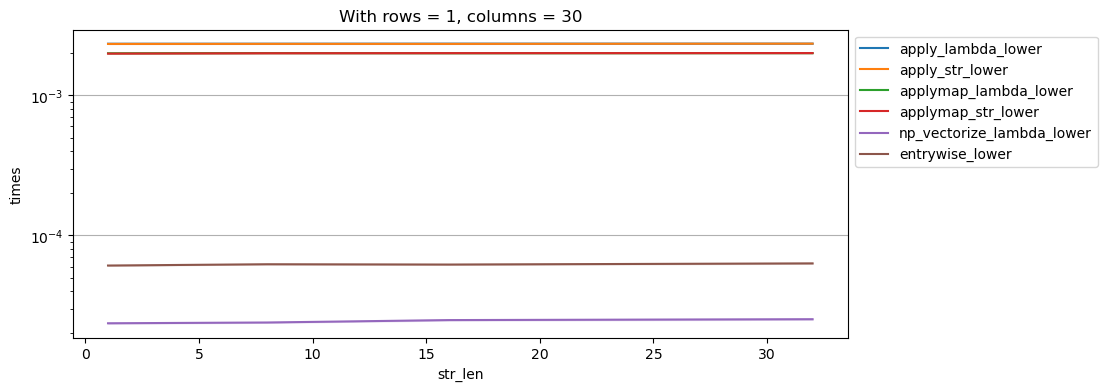

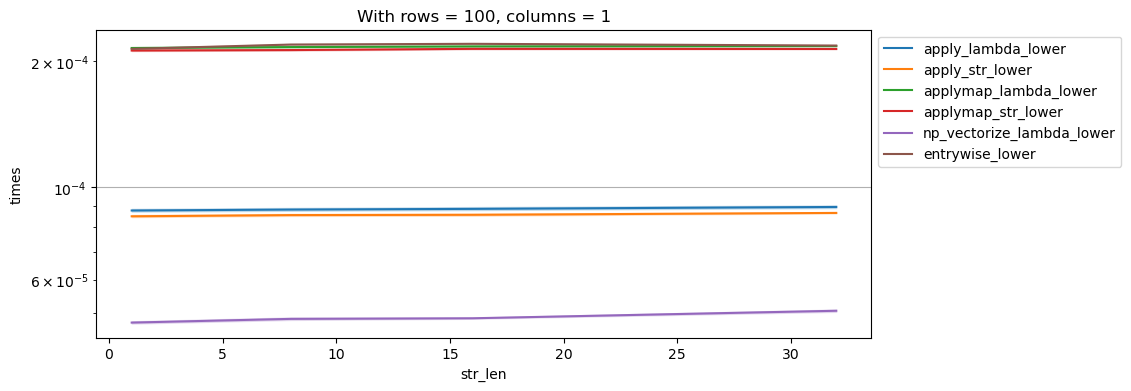

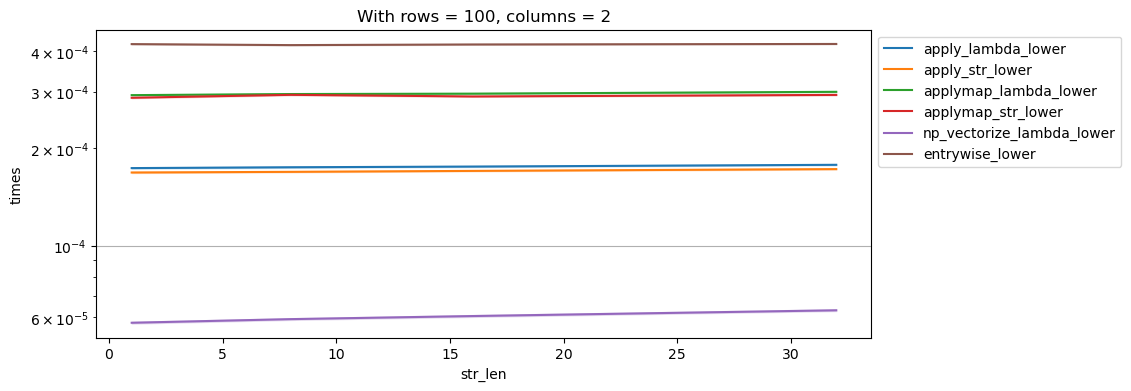

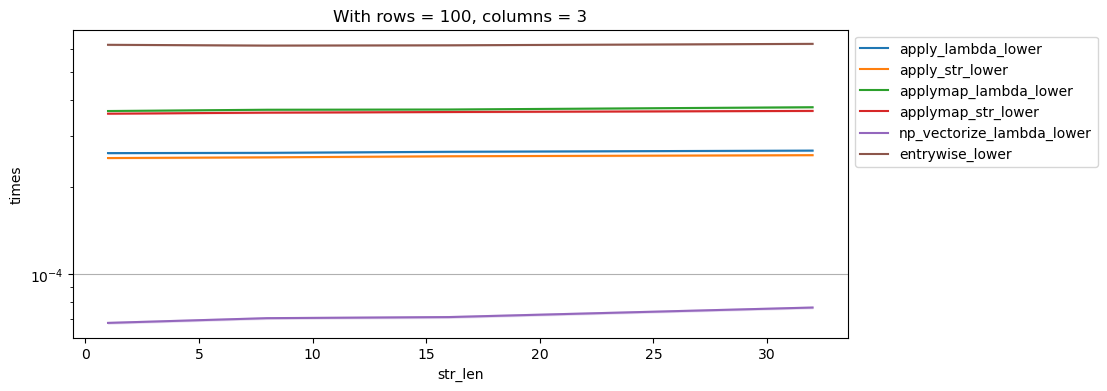

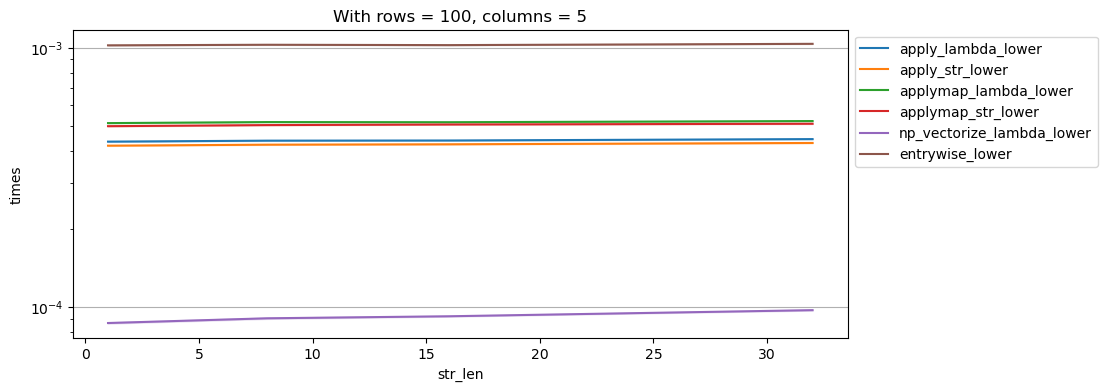

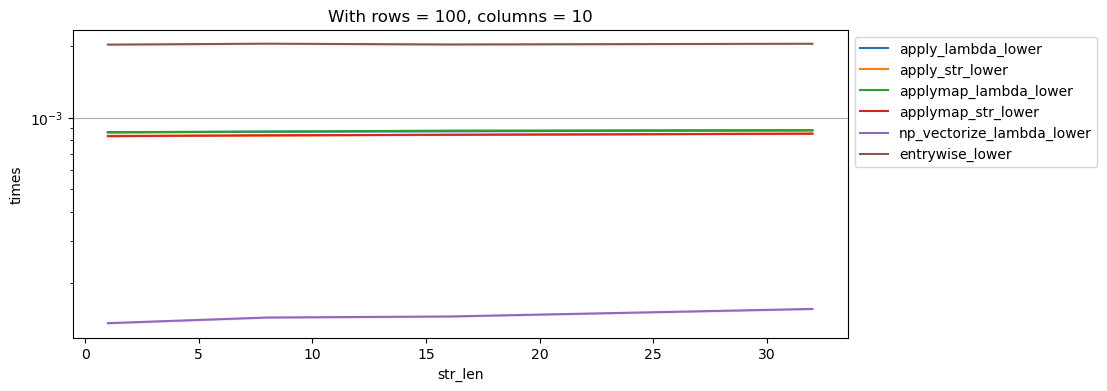

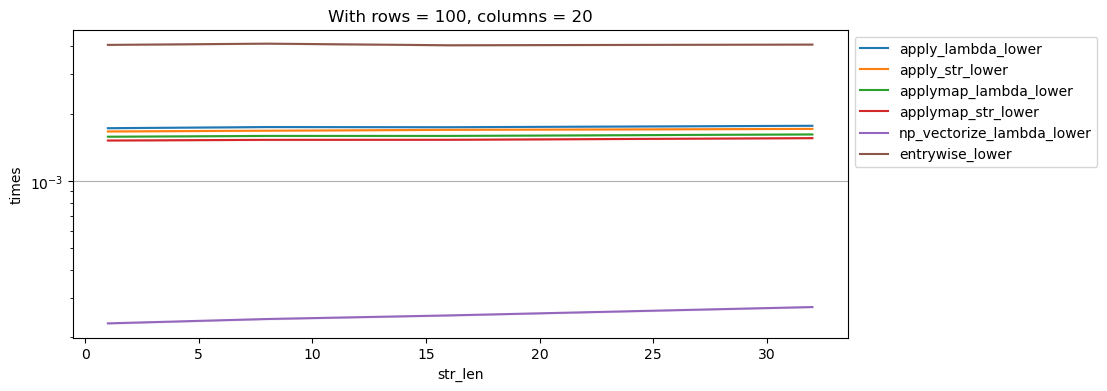

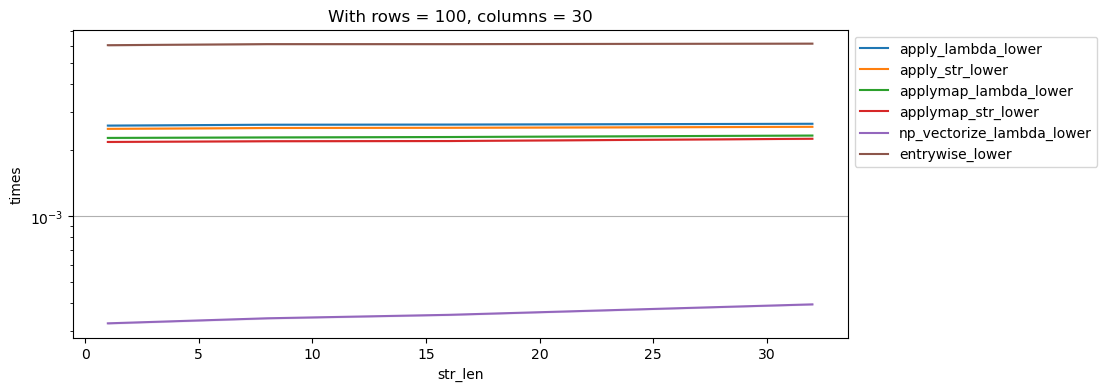

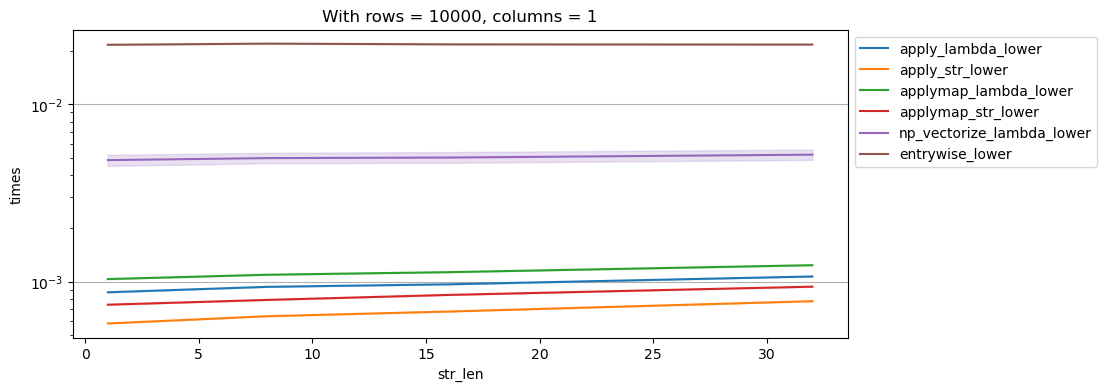

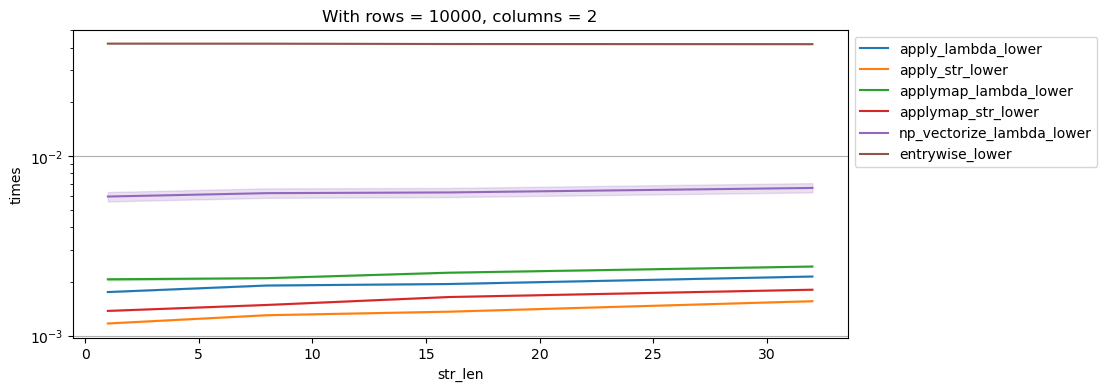

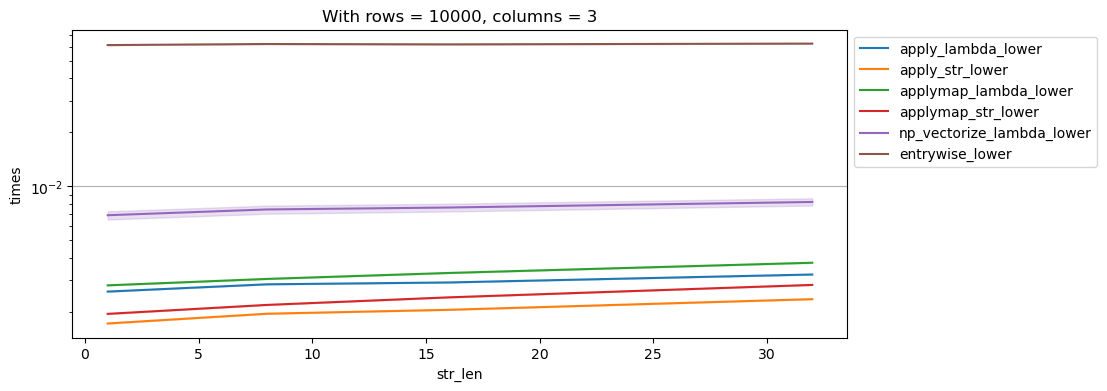

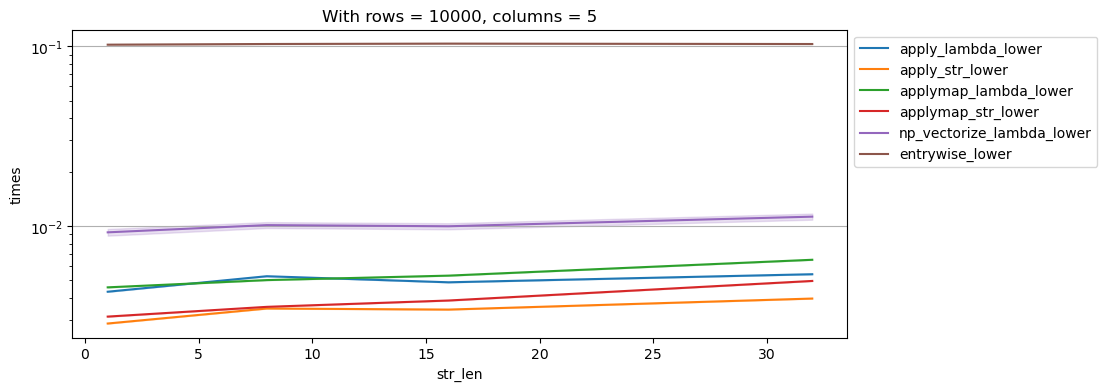

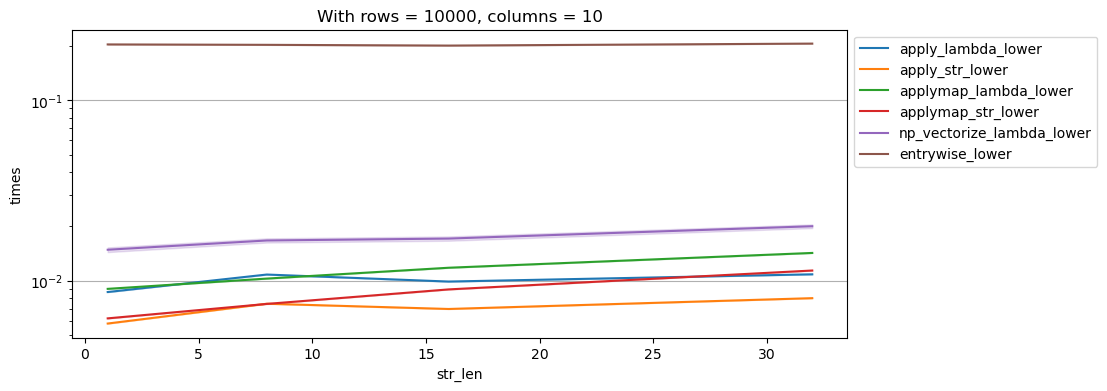

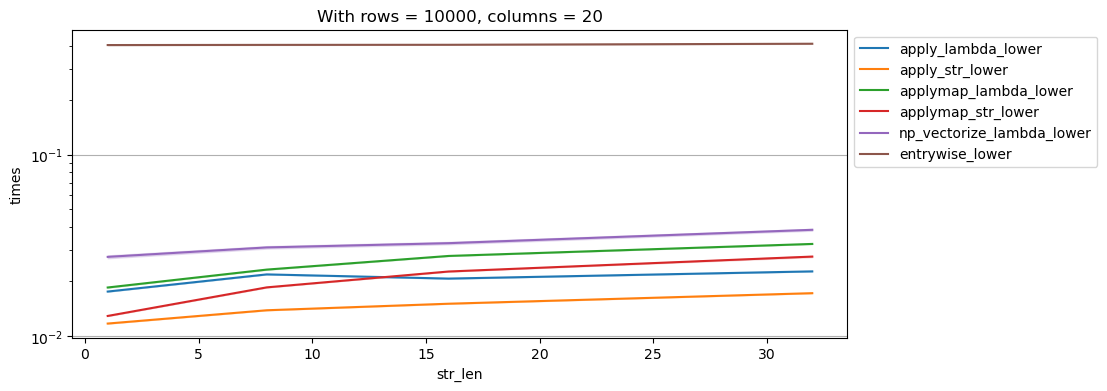

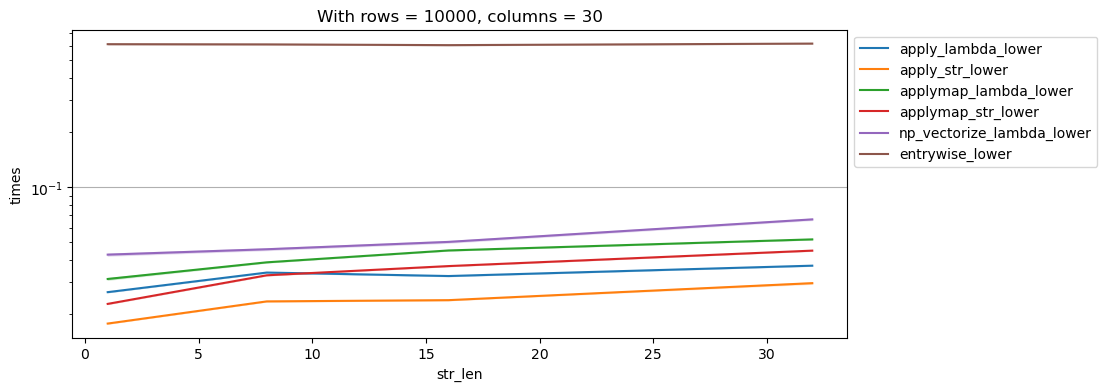

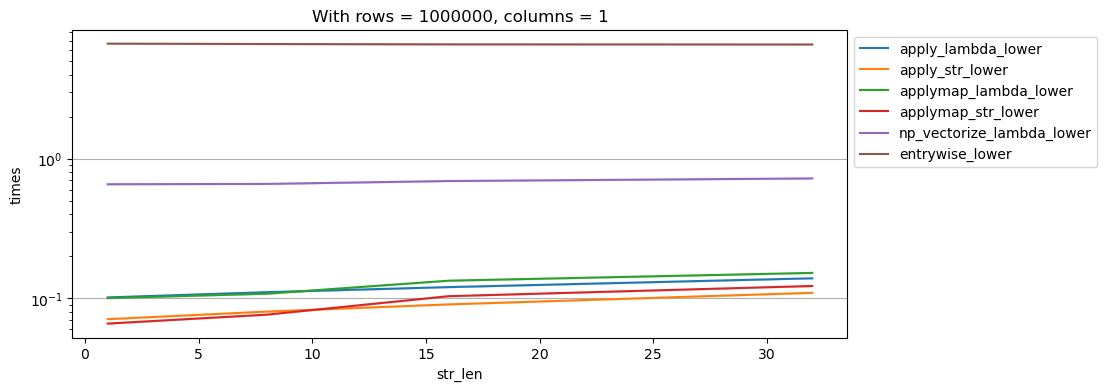

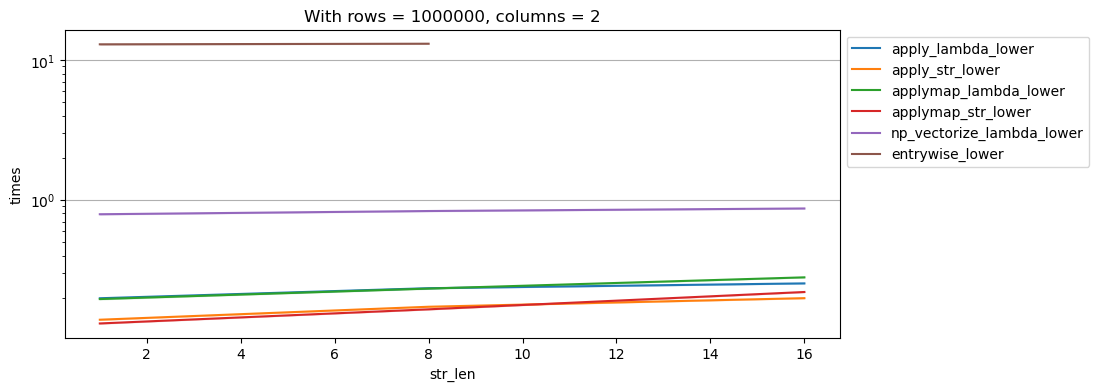

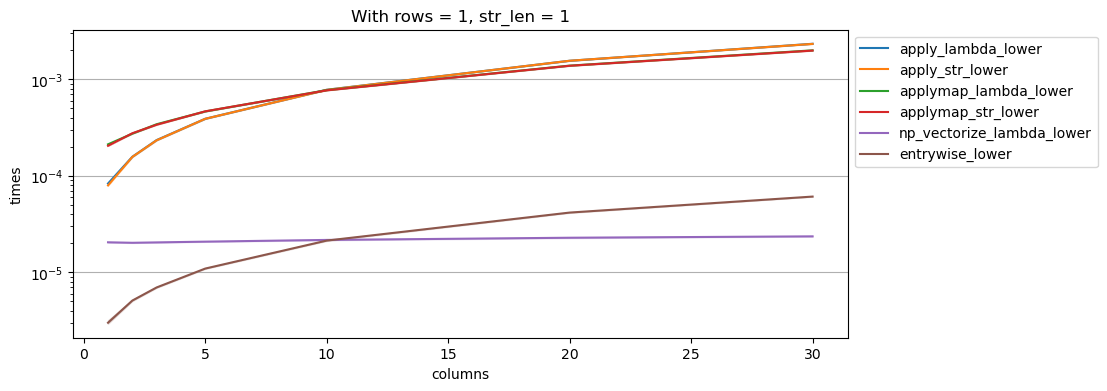

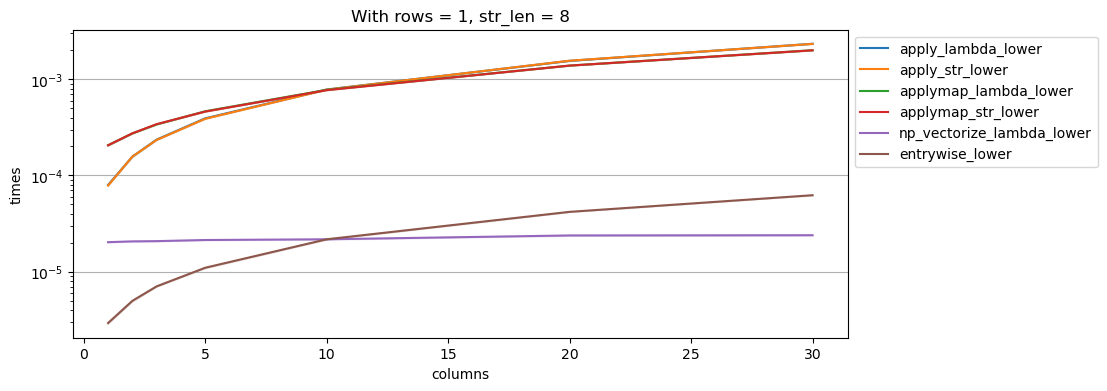

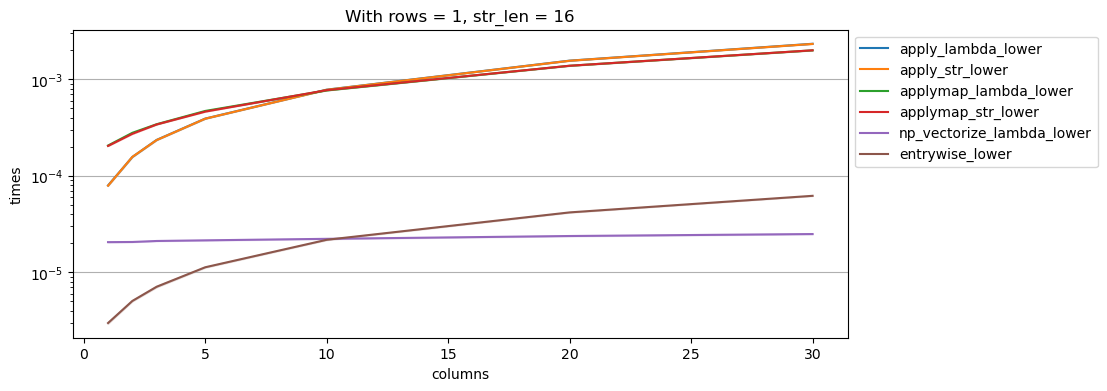

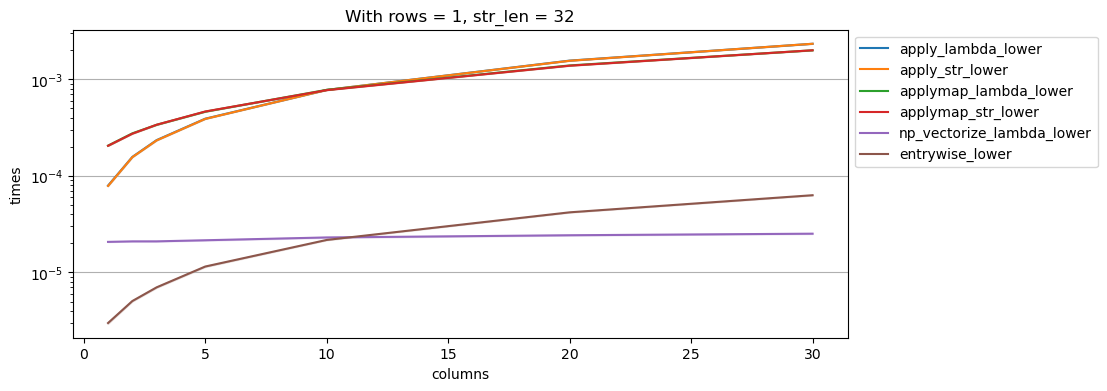

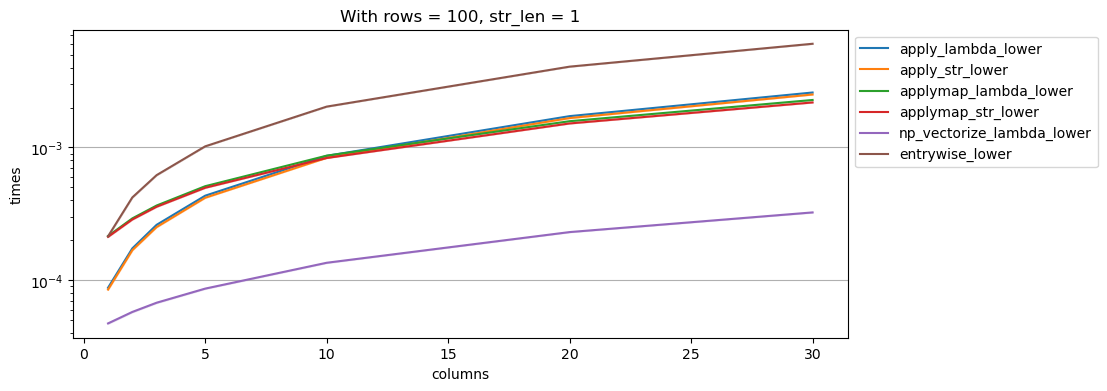

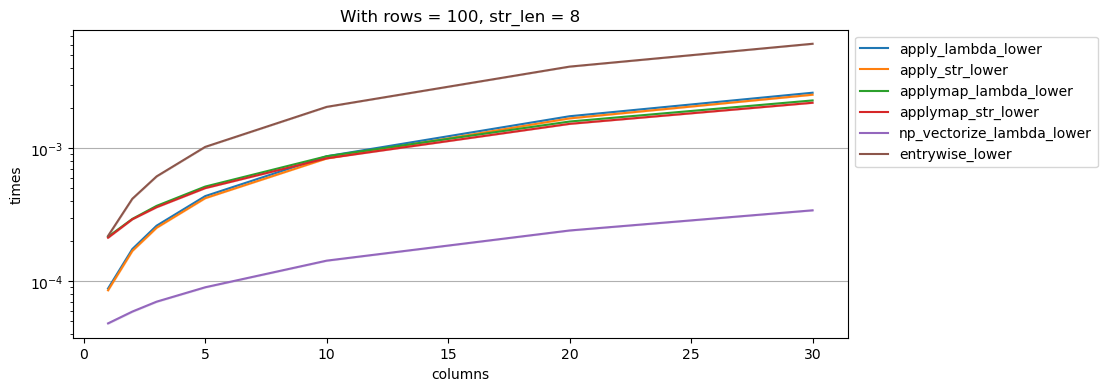

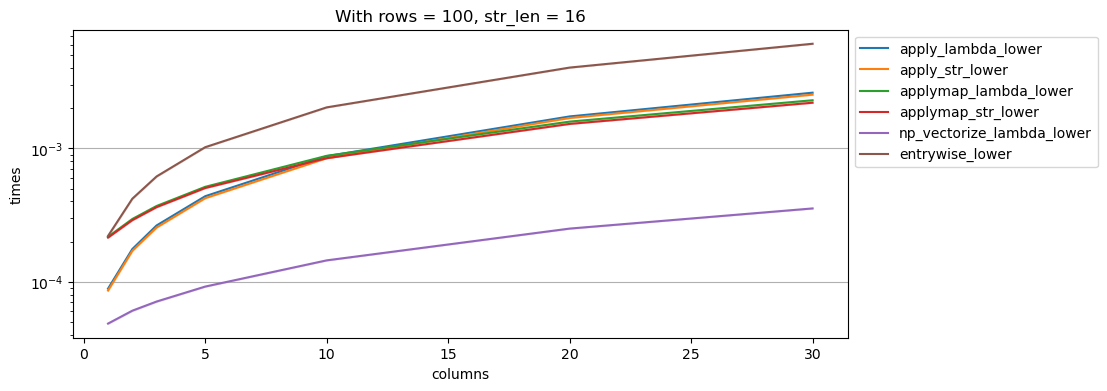

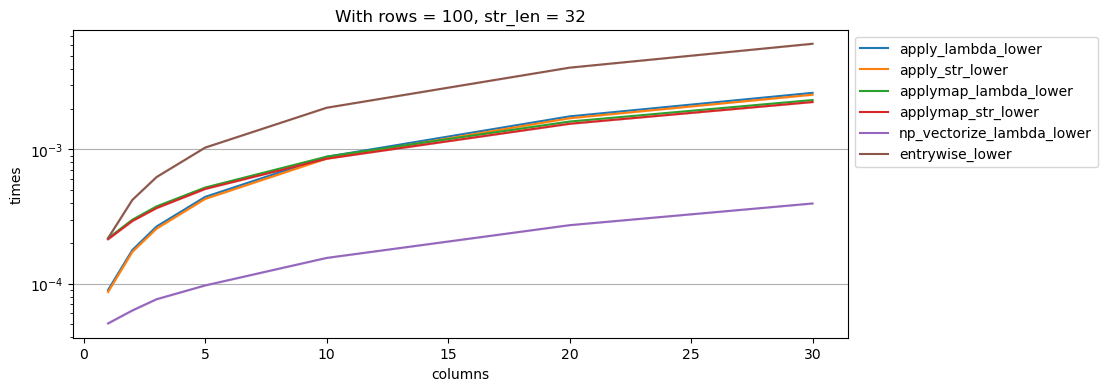

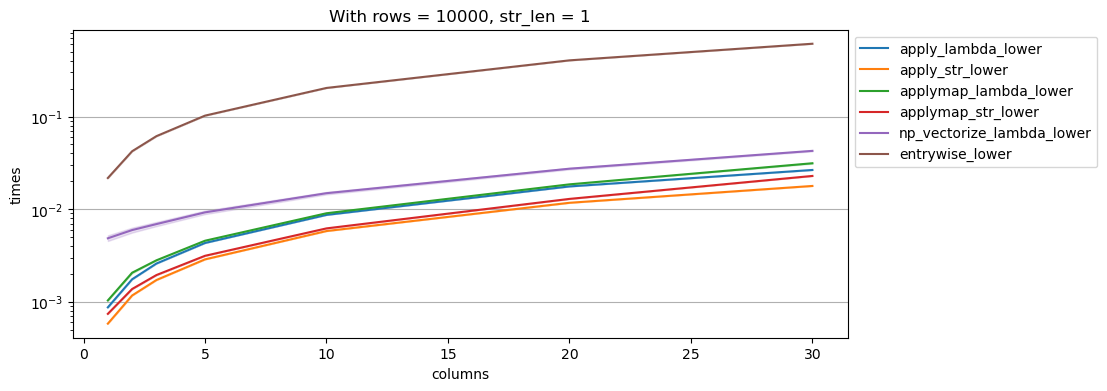

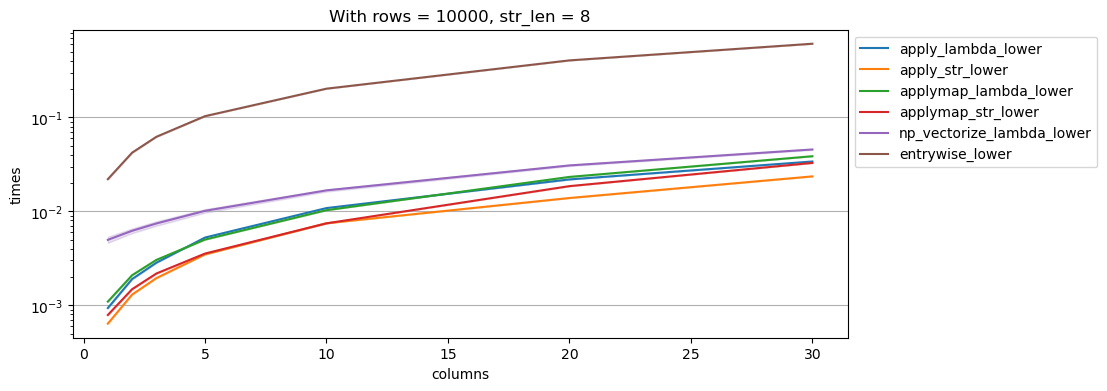

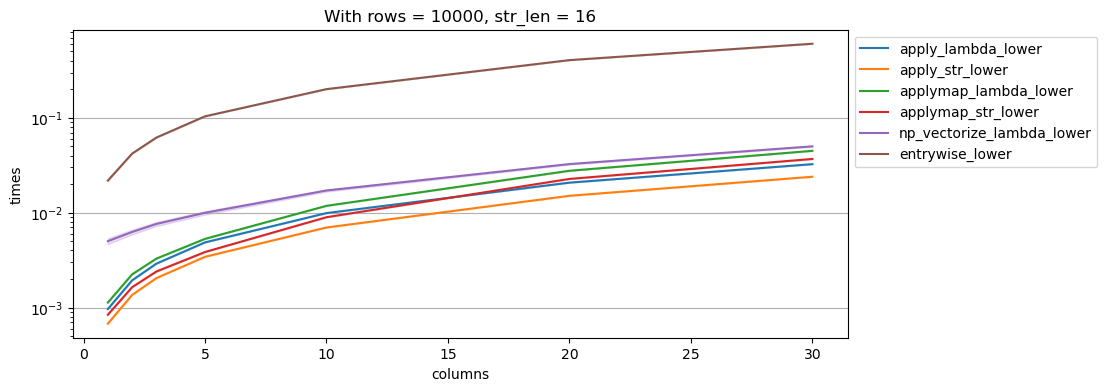

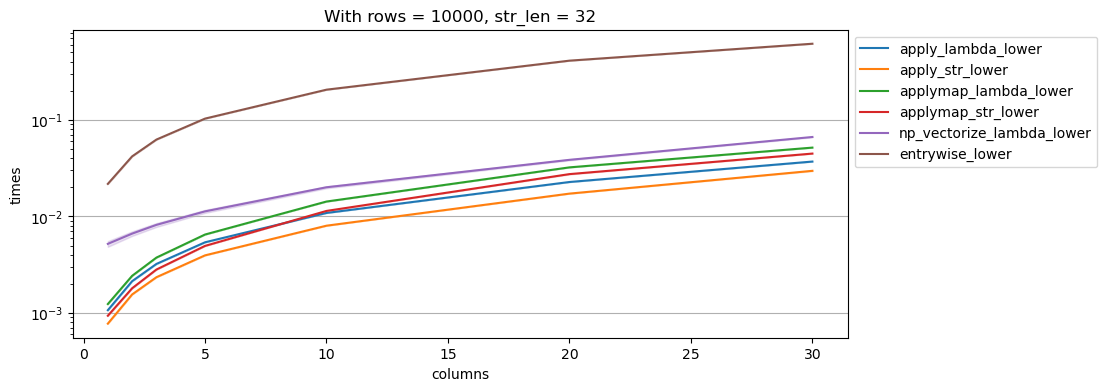

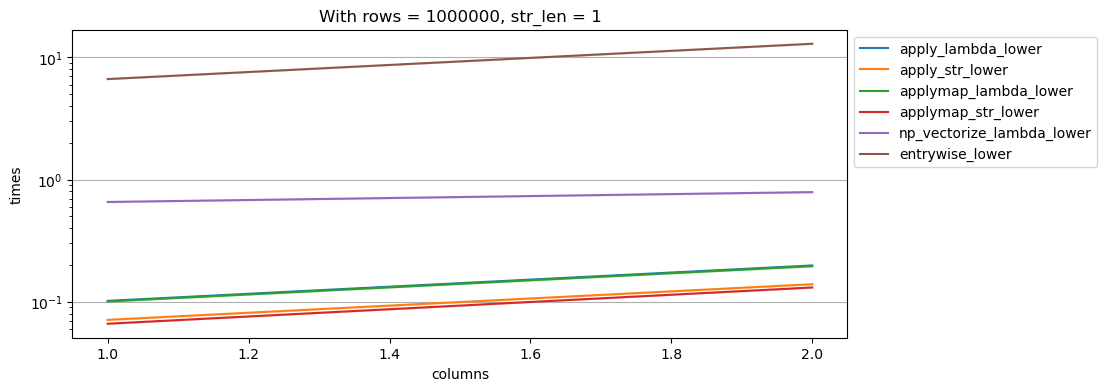

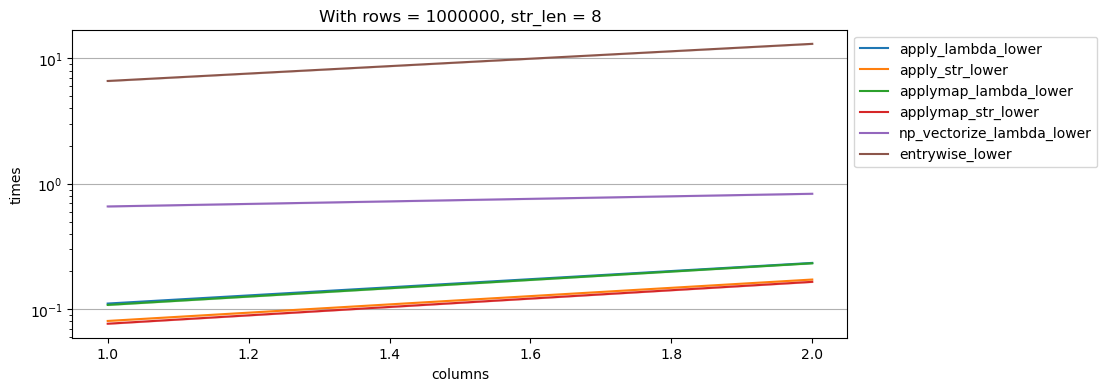

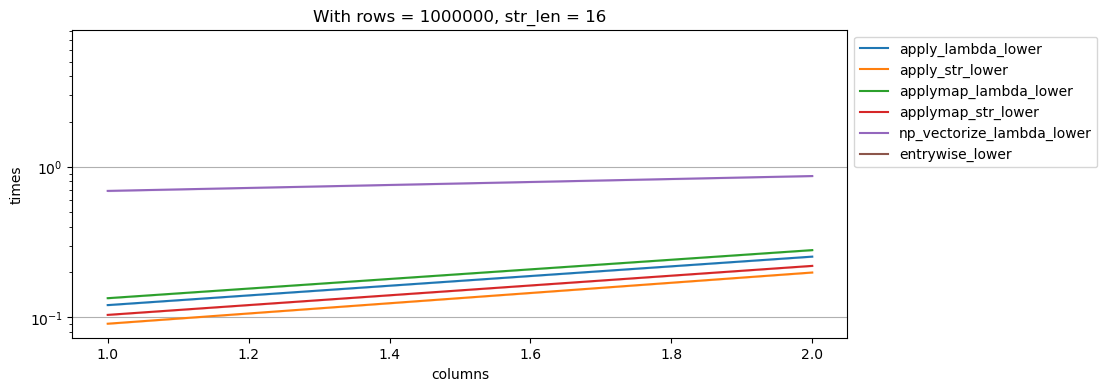

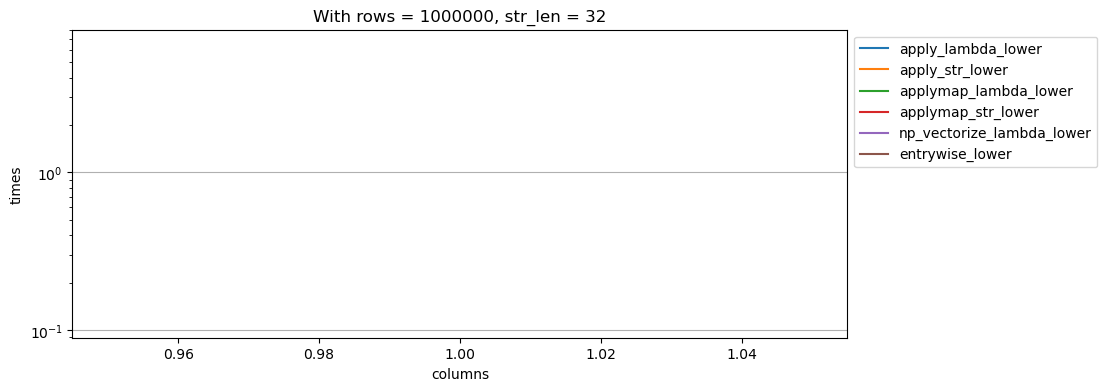

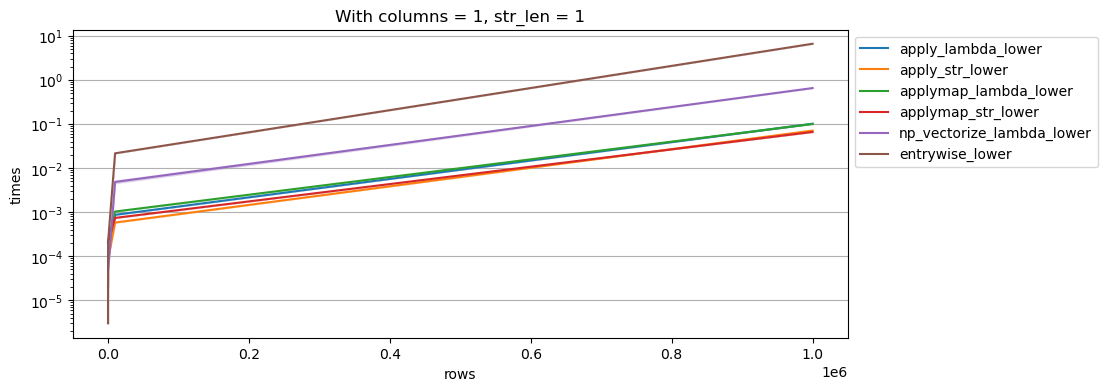

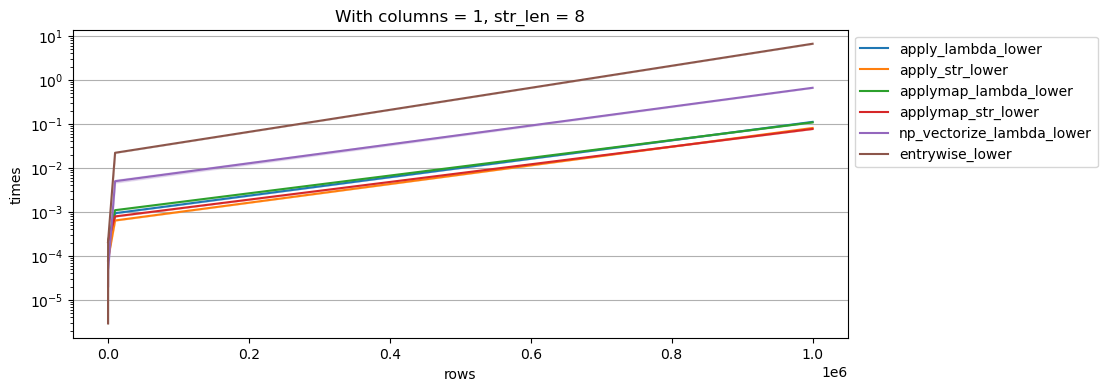

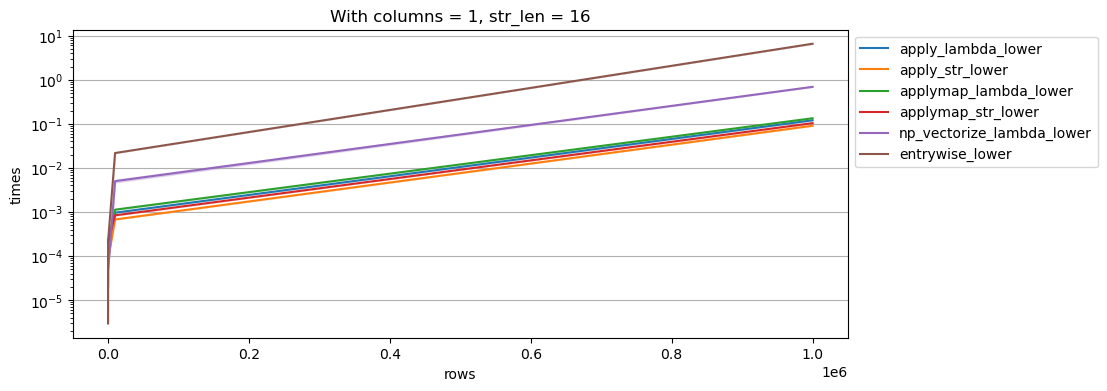

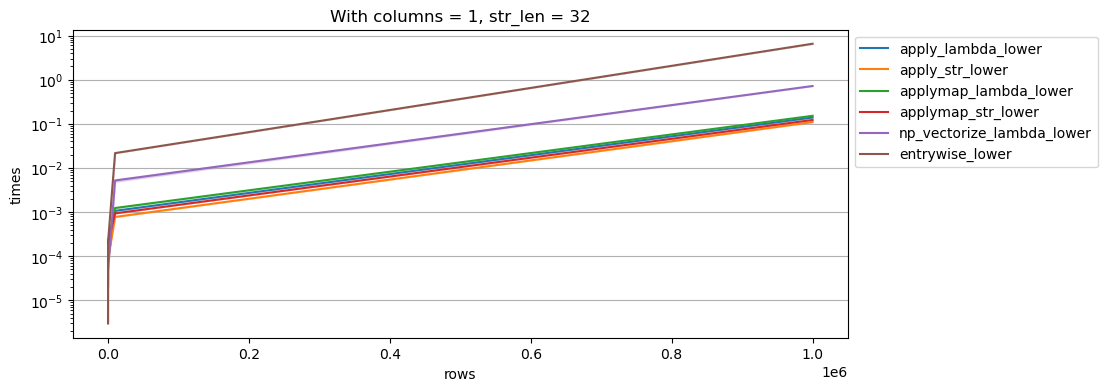

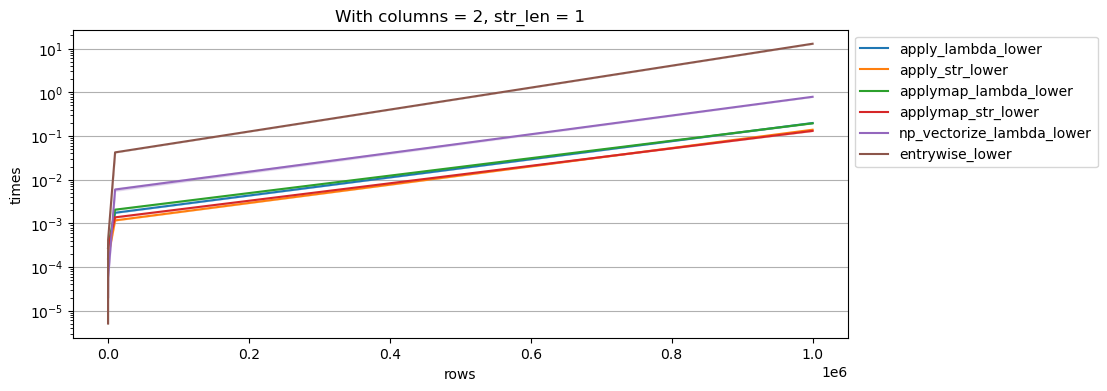

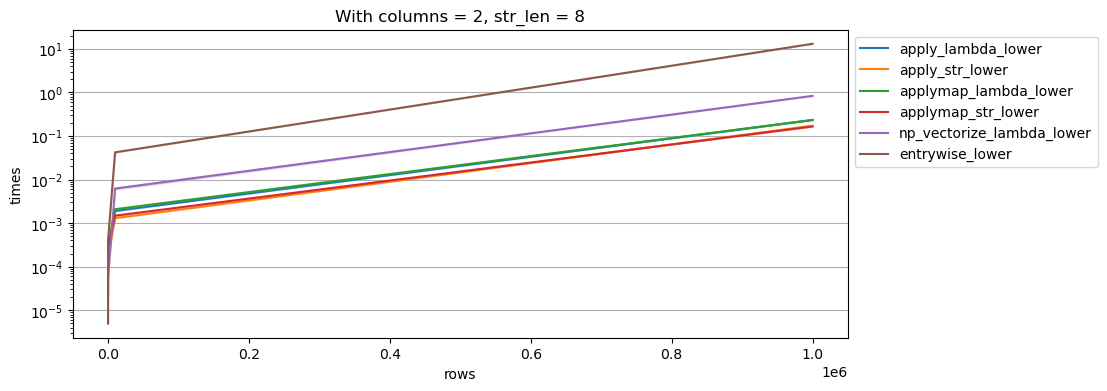

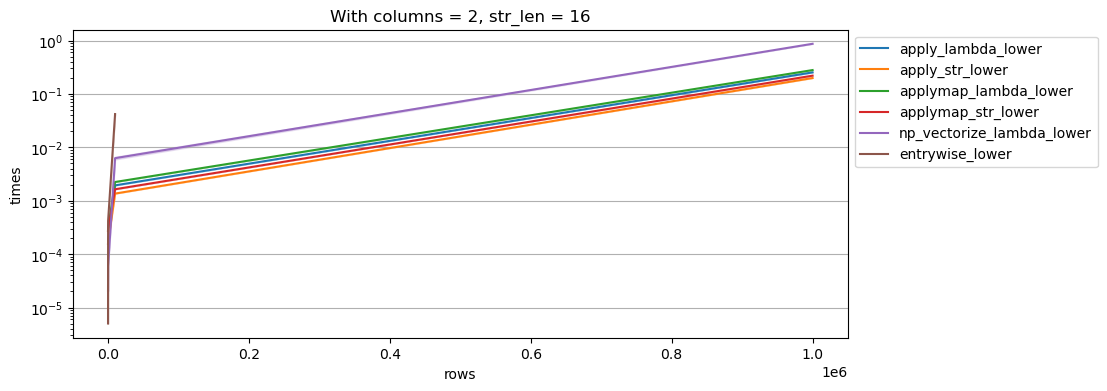

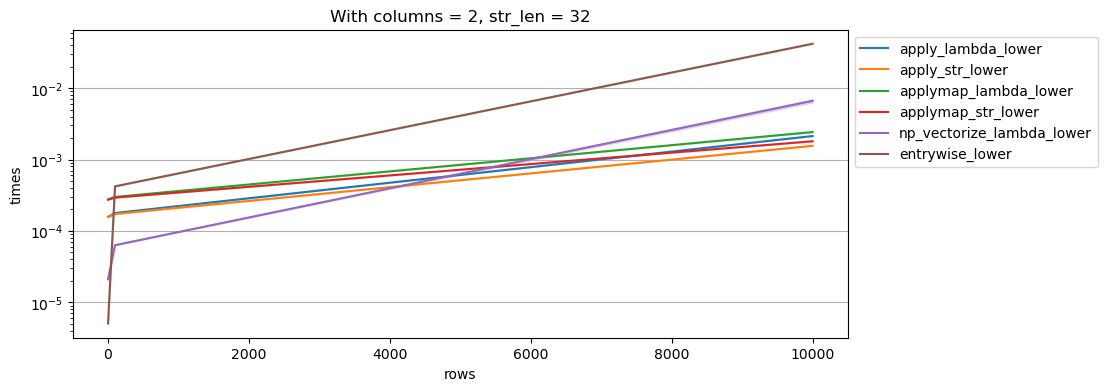

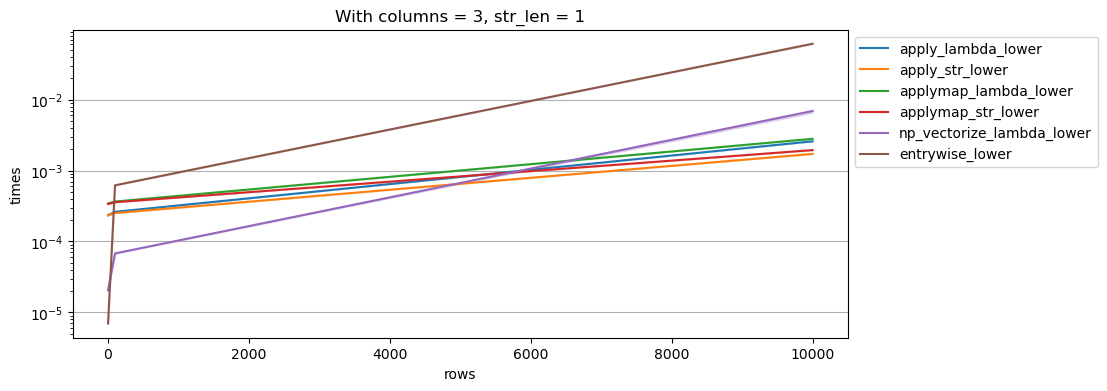

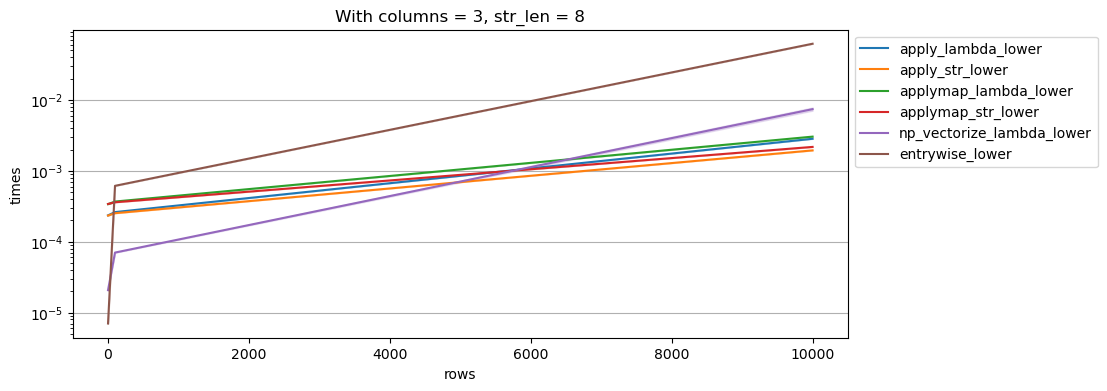

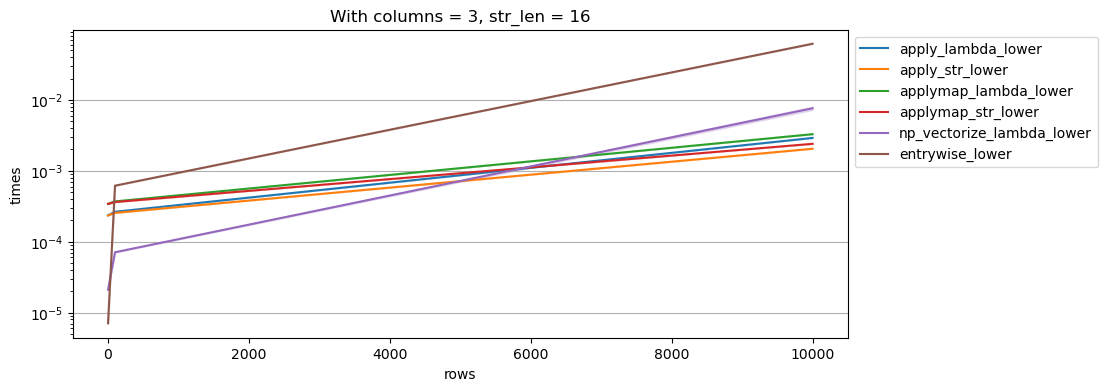

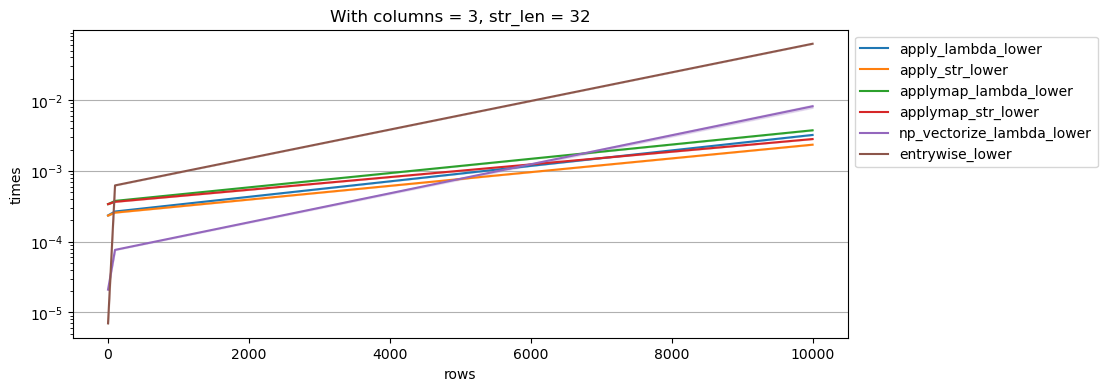

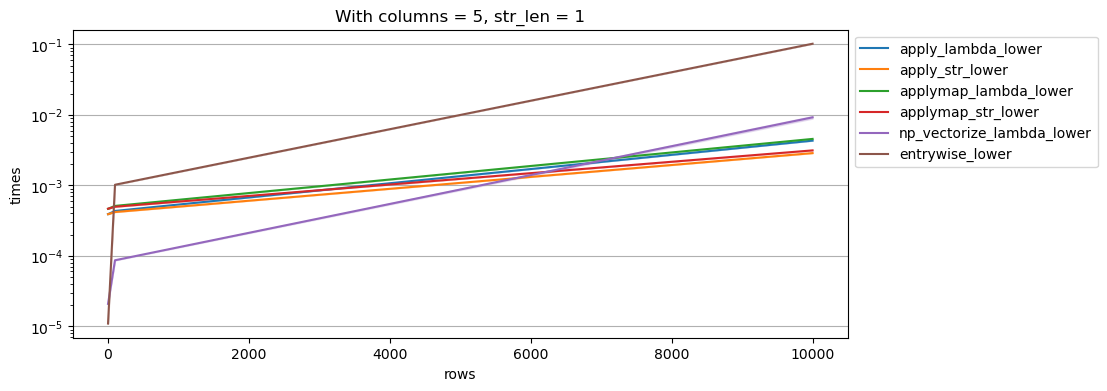

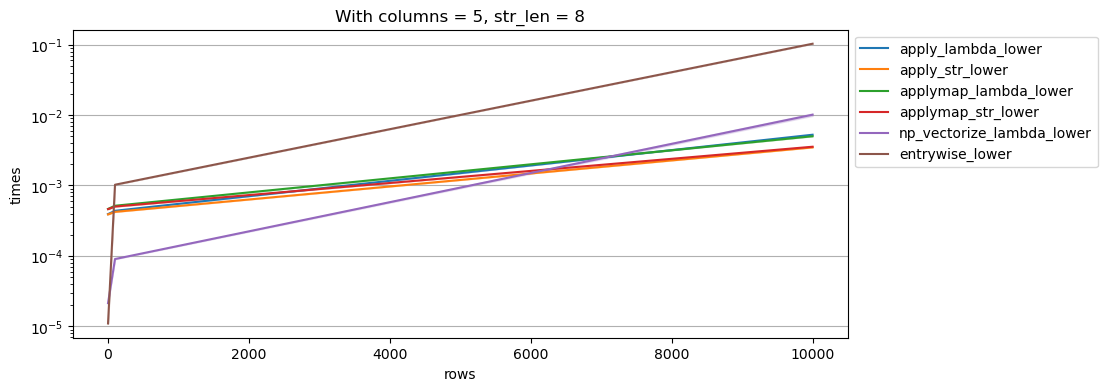

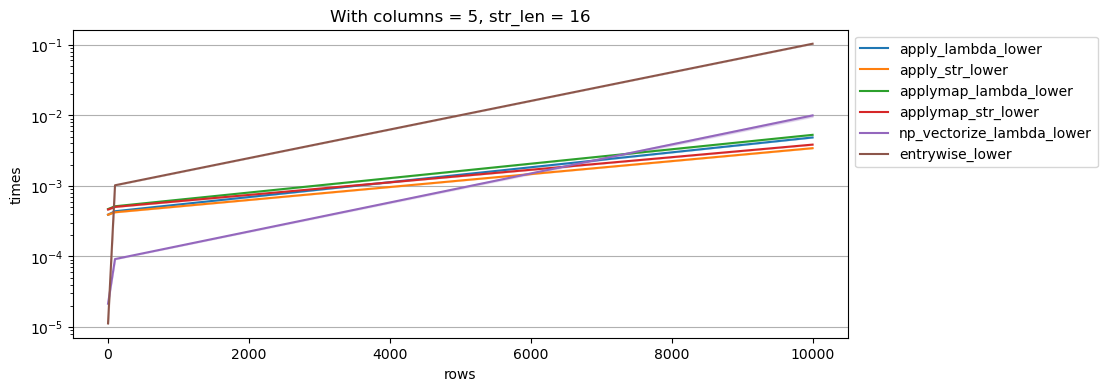

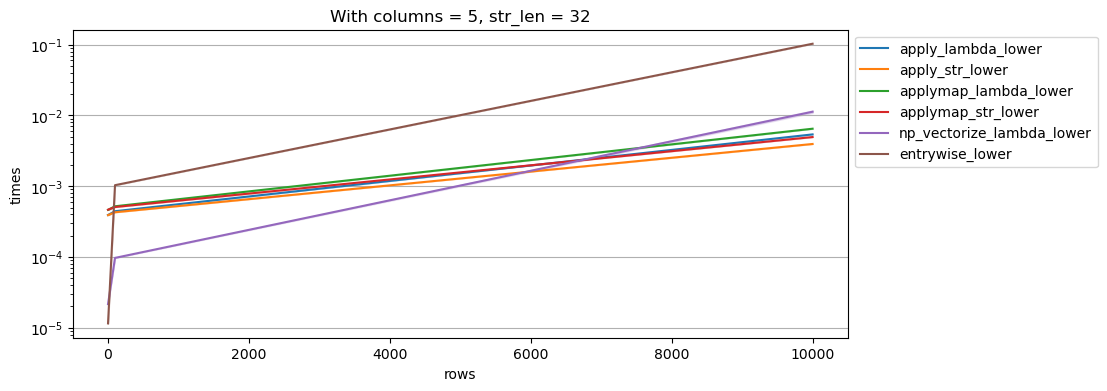

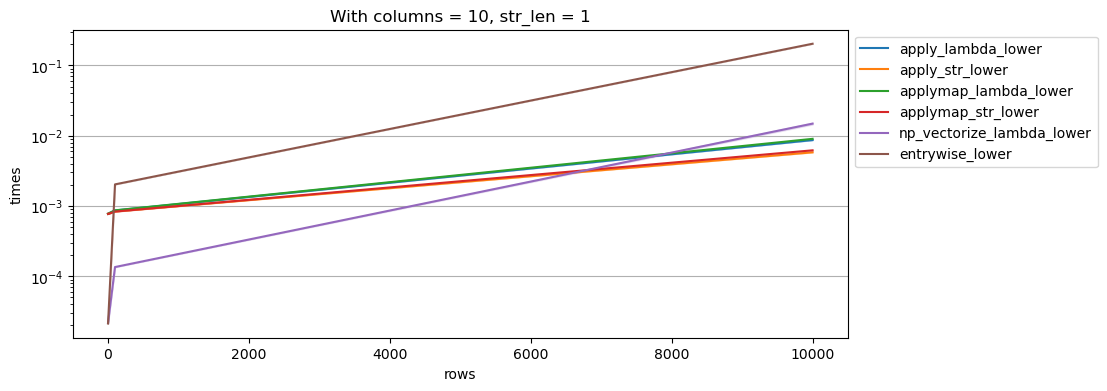

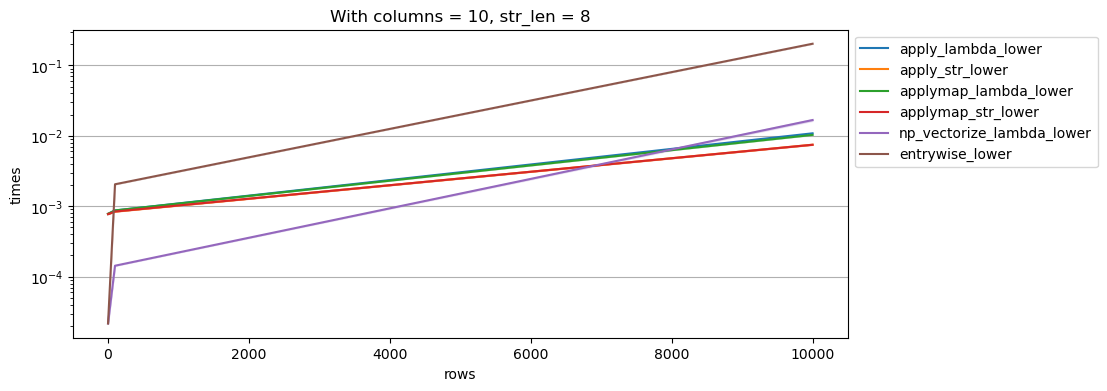

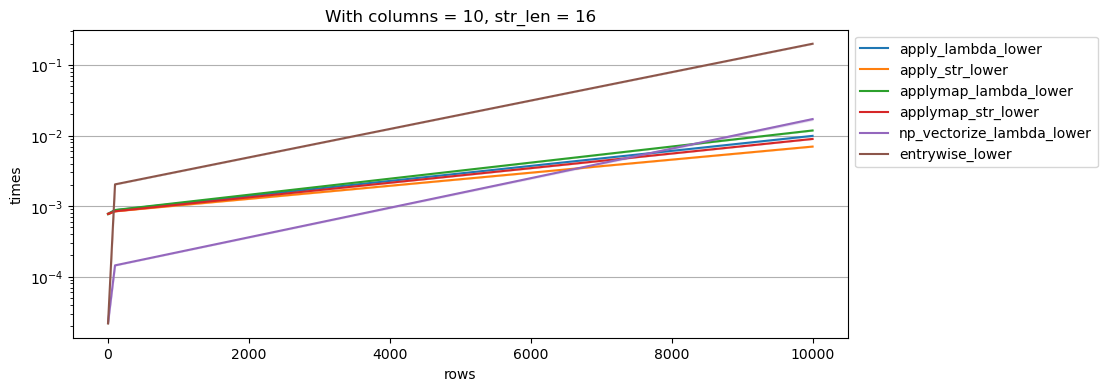

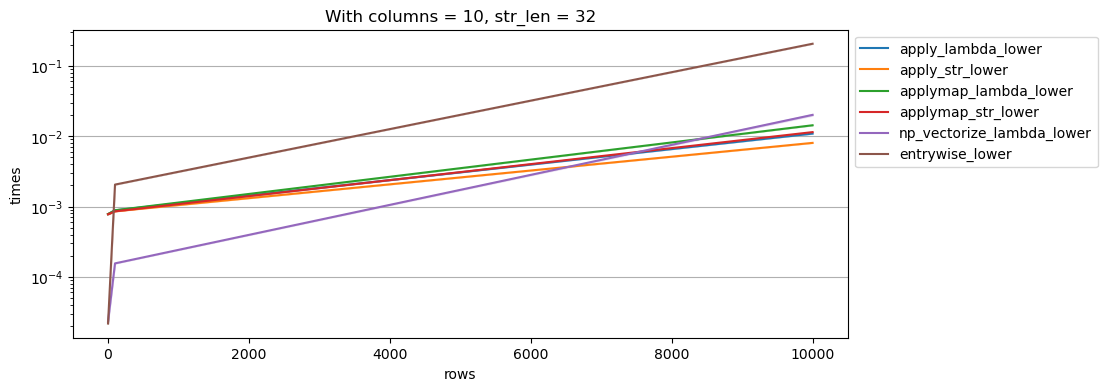

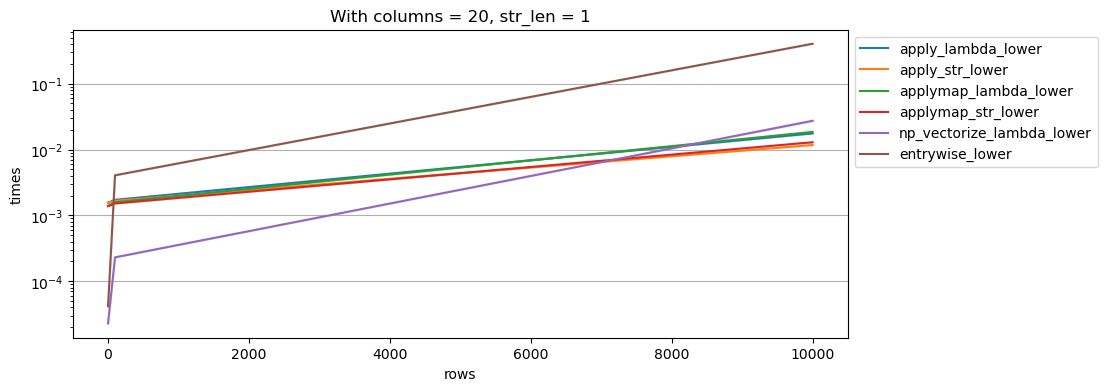

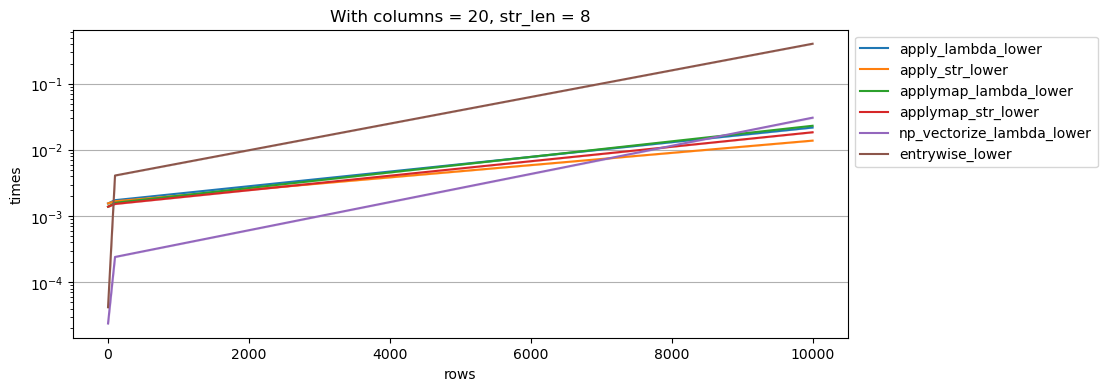

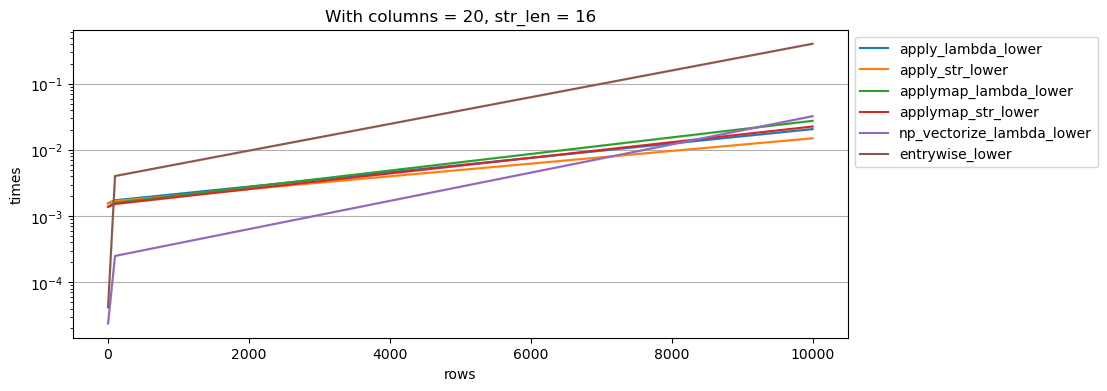

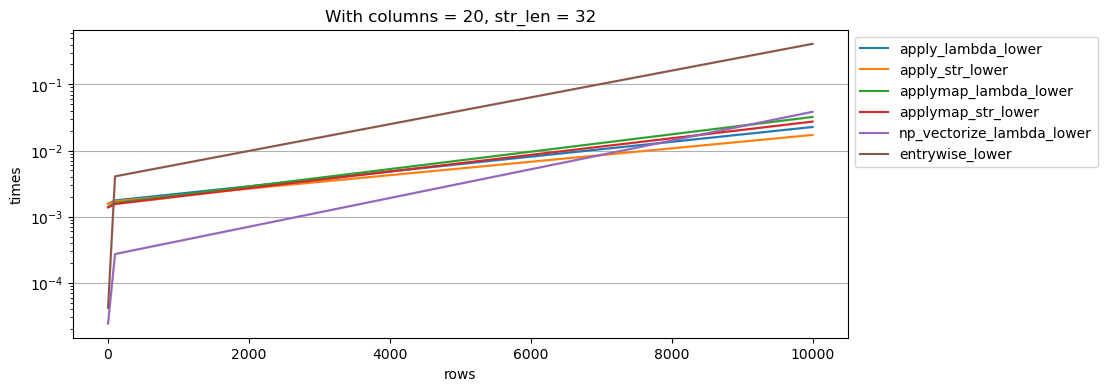

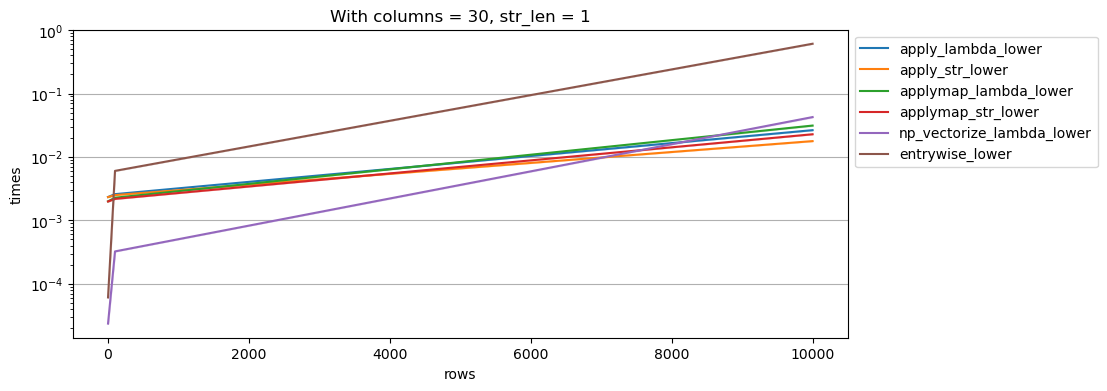

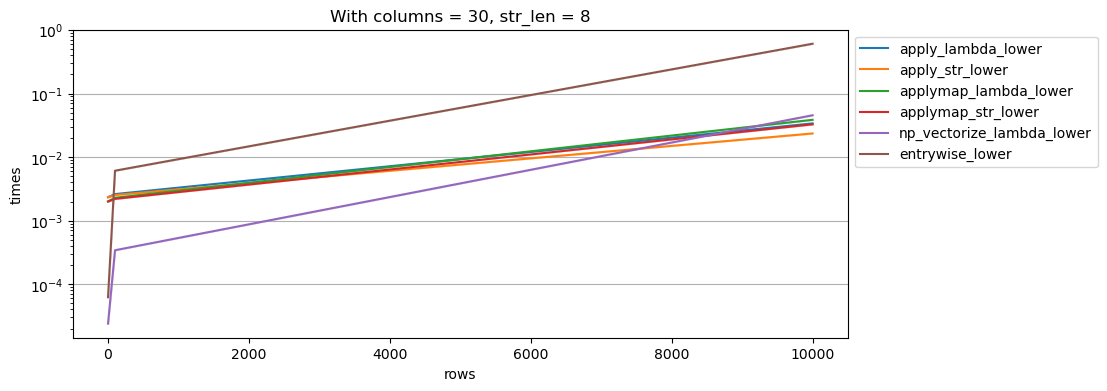

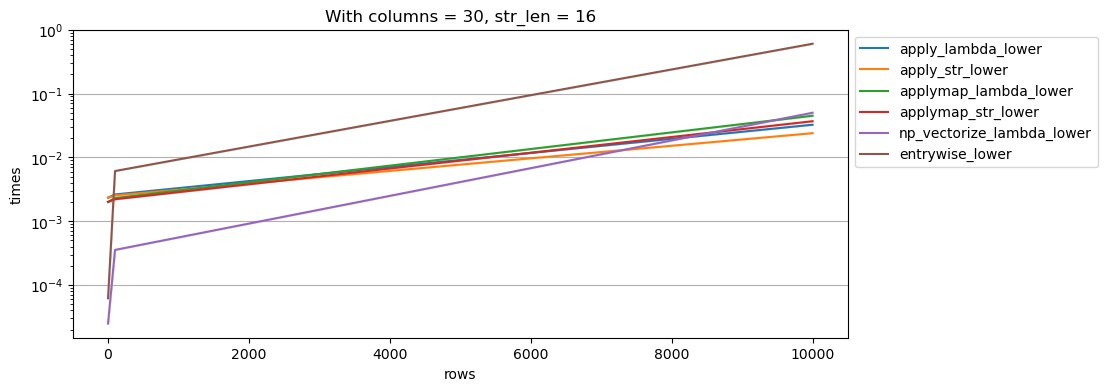

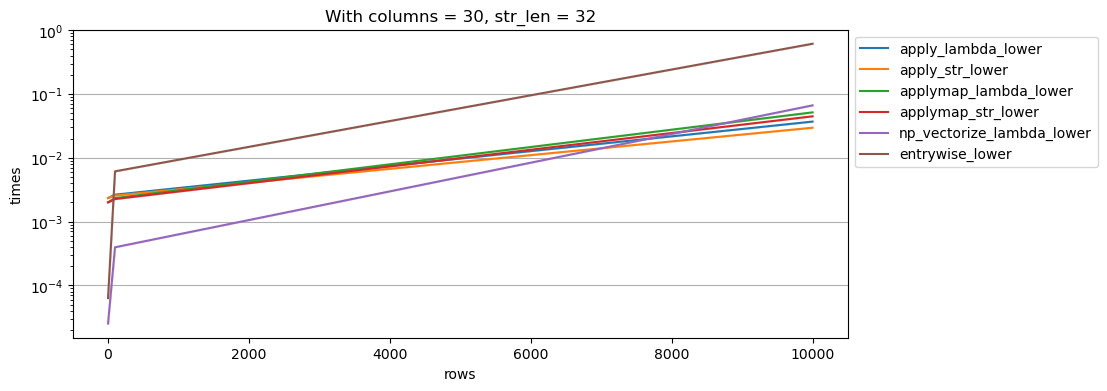

In [56]:
trends = {}
variables = [
    'rows',
    'columns', 
    'str_len'
]
for x1, x2 in combinations(variables, len(variables) - 1):
    y = variables.copy()
    y.remove(x1)
    y.remove(x2)
    y = y[0]
    trends[y] = {}
    for gp, gdf in times_df.groupby([x1, x2]):
        trends[y][gp] = plt.figure(figsize = [10,4])
        sns.lineplot(
            data = gdf,
            x = y,
            y = 'times',
            hue = 'function',
        )
        plt.yscale('log')
        plt.legend(loc = 'upper left', bbox_to_anchor = [1, 1])
        plt.gca().get_yaxis().grid()
        plt.title('With {} = {}, {} = {}'.format(x1, gp[0], x2, gp[1]))
        plt.show()

- with low rows and columns actually string length 1 has a worse performance? why? I'm not normalizing things by length of the string here!
- we can see a slight upward trends here and it seems very real, but for most cases it's not enough to change move the order of the lines. The log scale of the y axis makes is so that only the trend in the smaller values can be seen.
- for the cases where the lines do cross each other, was I right to assume the length doesn't matter? Here it seems it does, and it says something about the implementation of the str.lower vs ''.lower
- all of these are plotted with 95% confidence intervals, usually only the ones in the middle can be seen to have an interval, again due to log scale of the y-axis probably.

Here is one such example, keep in mind that I have only 4 points to make each curve here at 1, 8 ,16 , and 32.

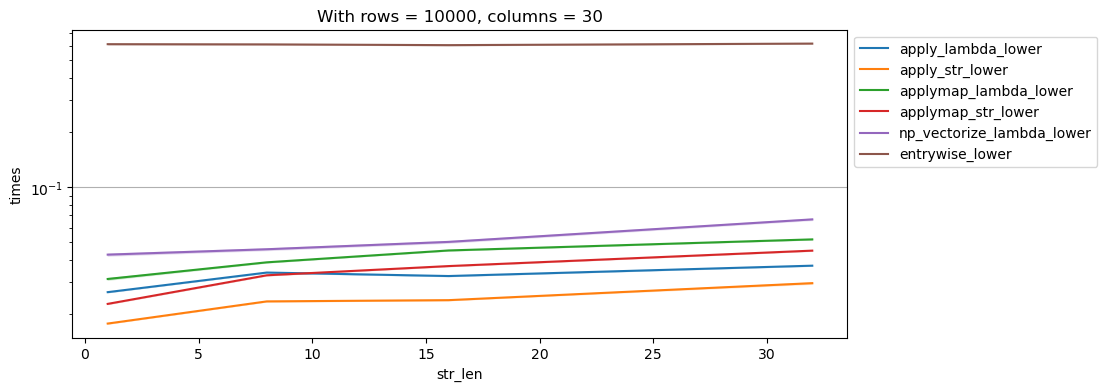

In [57]:
trends['str_len'][(10000, 30)]

OK, I can't decide right now if I was correct in ignoring the length of the strings but let's pull them together againa nd look at how rows and columns are affecting the overall performance. I'm just surprised the confidence intervals remain so small after adding so much variability.

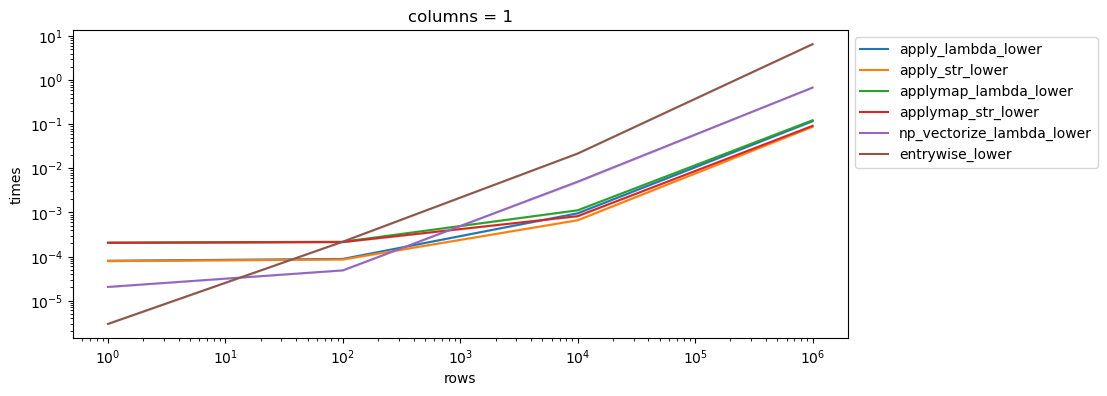

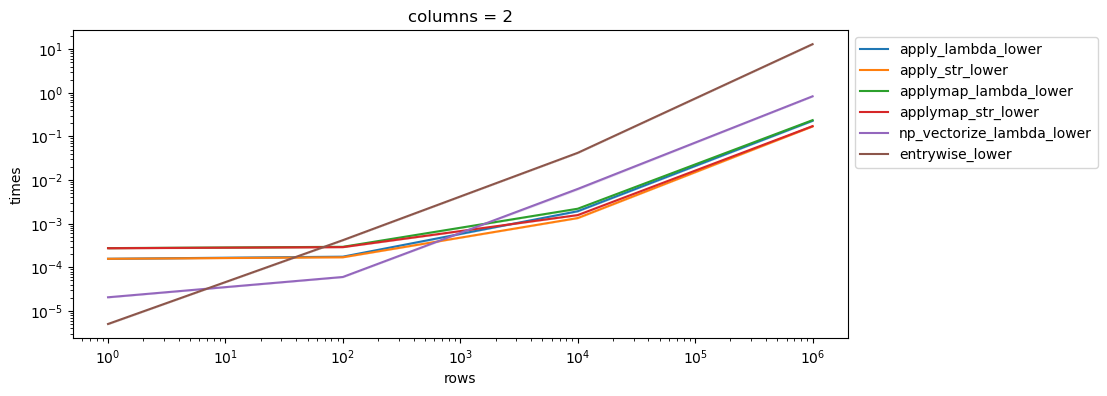

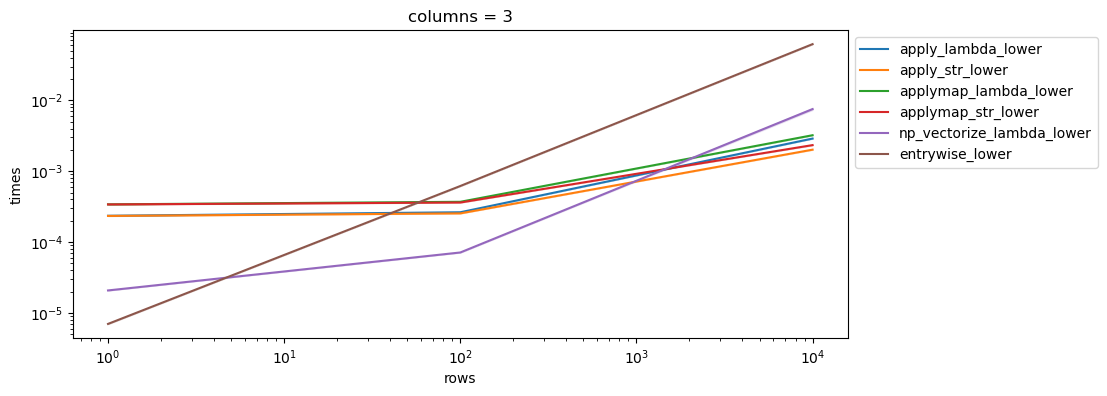

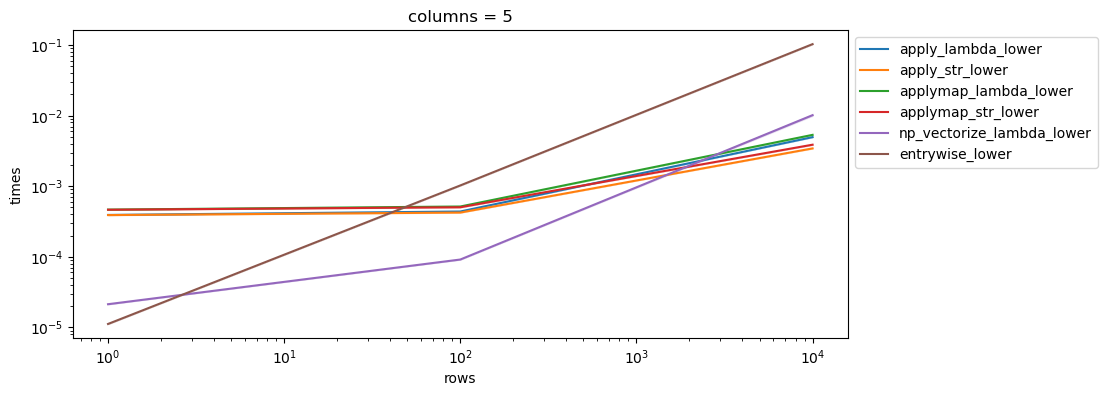

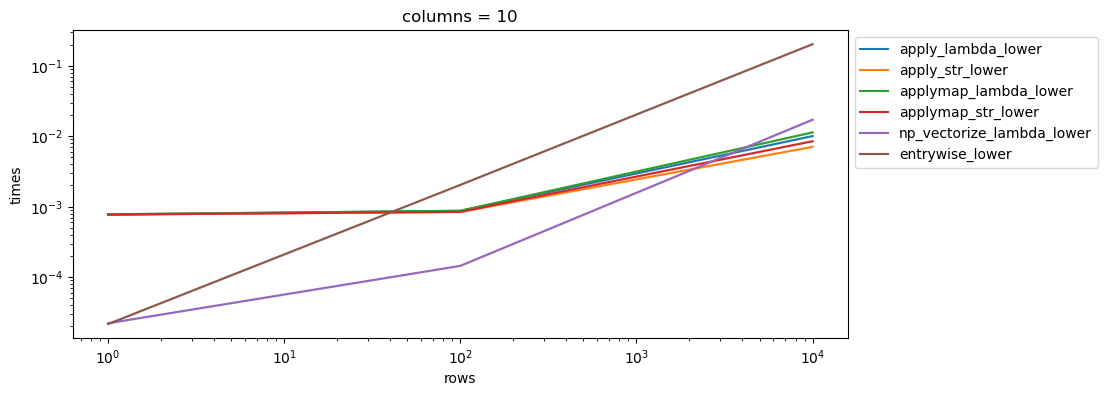

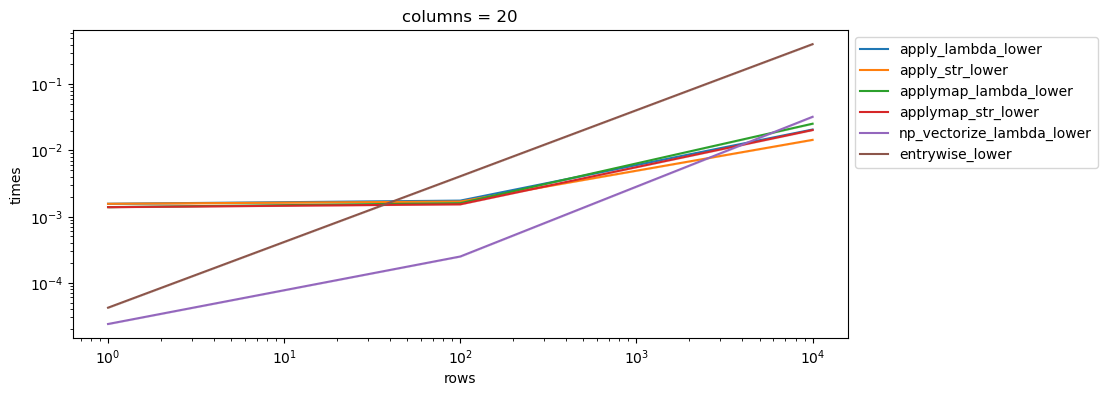

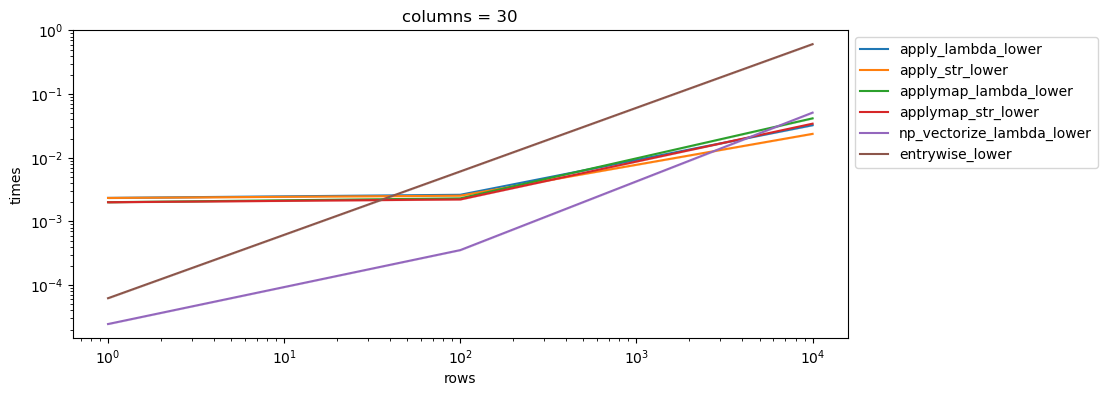

In [60]:
trends2 = {}
variables = [
    'rows',
    'columns', 
]
x = 'rows'
y = 'columns'
for gp, gdf in times_df.groupby([y]):
    trends2[gp] = plt.figure(figsize = [10,4])
    sns.lineplot(
        data = gdf,
        x = x,
        y = 'times',
        hue = 'function'
    )
    plt.title('{} = {}'.format(y, gp))
    plt.yscale('log')
    plt.xscale('log')

    plt.legend(loc = 'upper left', bbox_to_anchor = [1, 1])
    plt.show()

right away we see that as rows increase the nested for loop and numpy.vectorize becoe increasingly worse in all cases. So, let's remove them and see if we get a better picture of the rest. The log-log scale shows how non-linear things actually are.

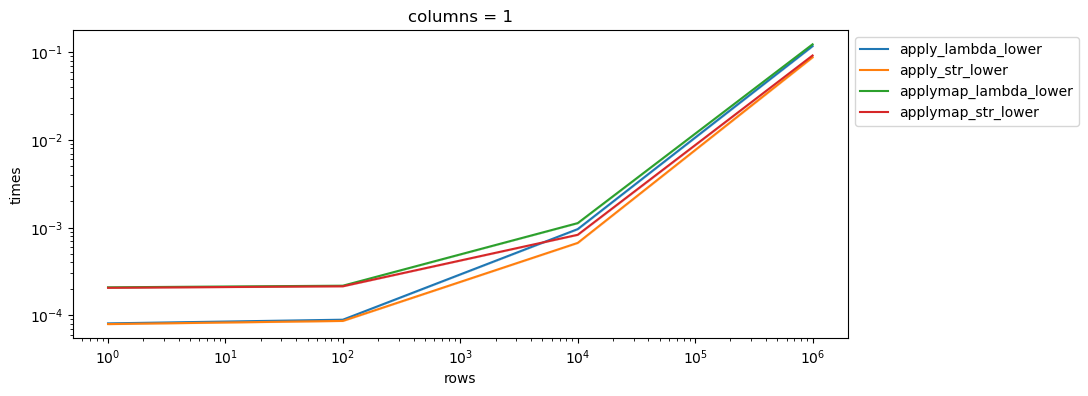

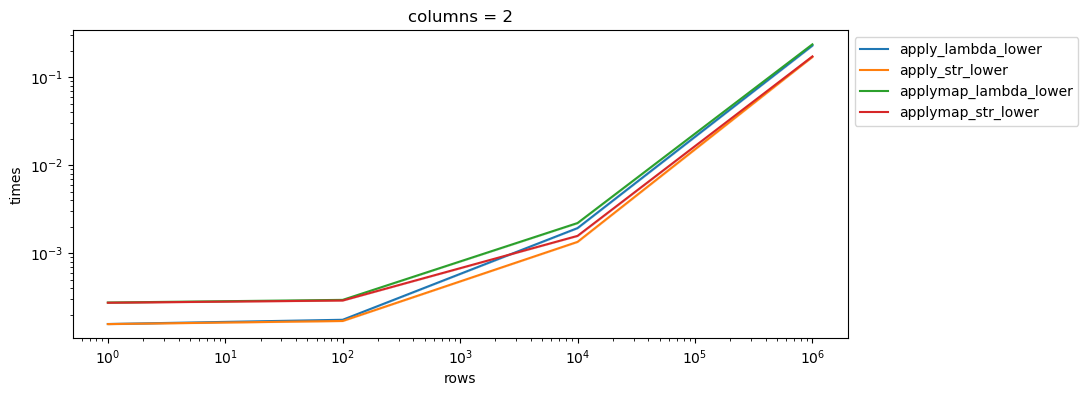

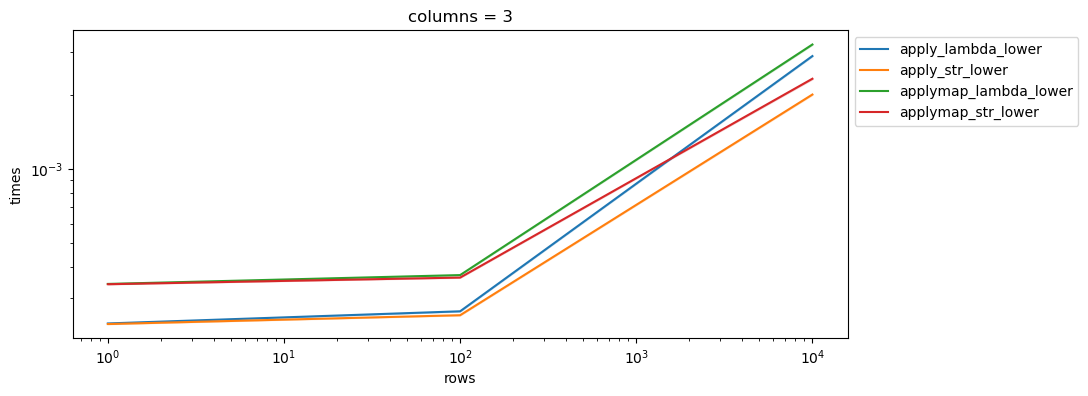

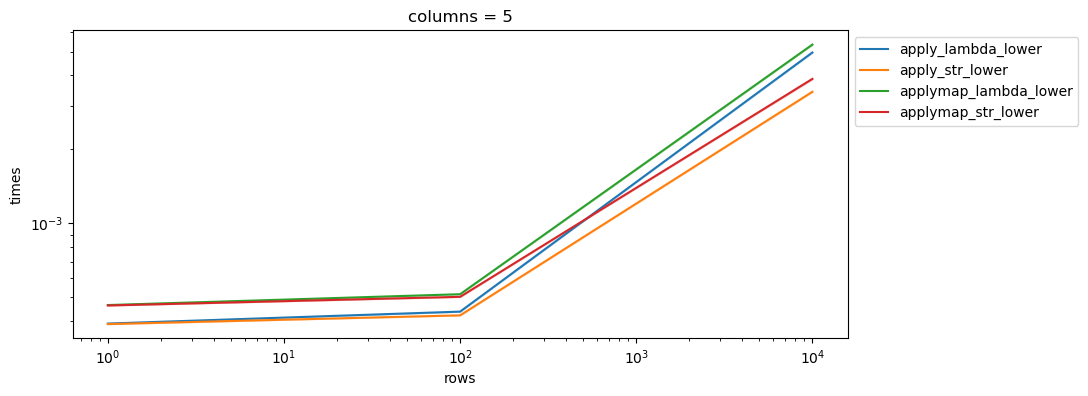

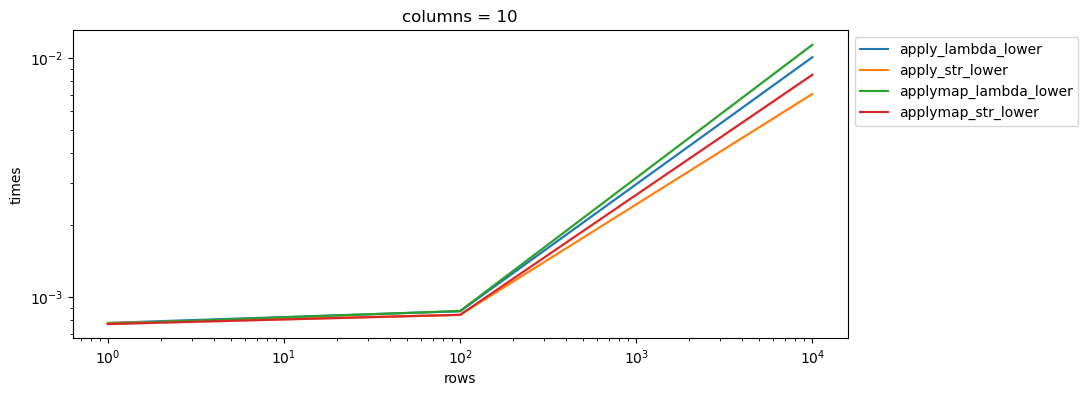

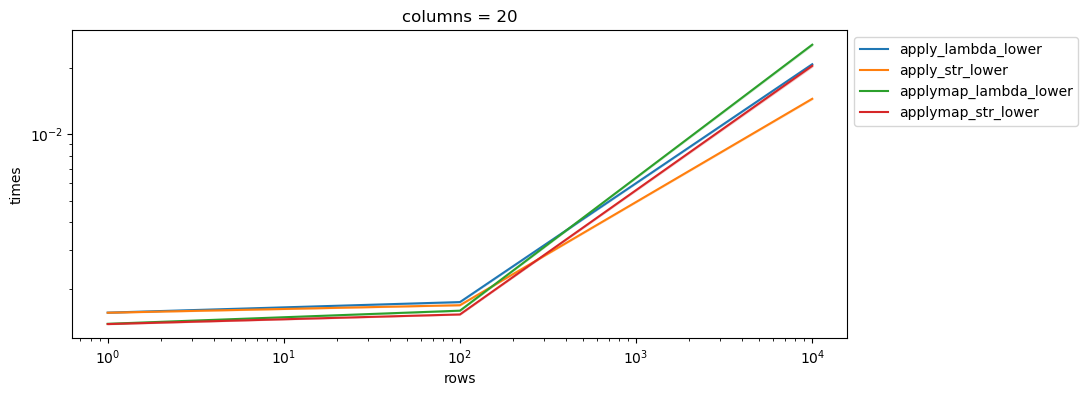

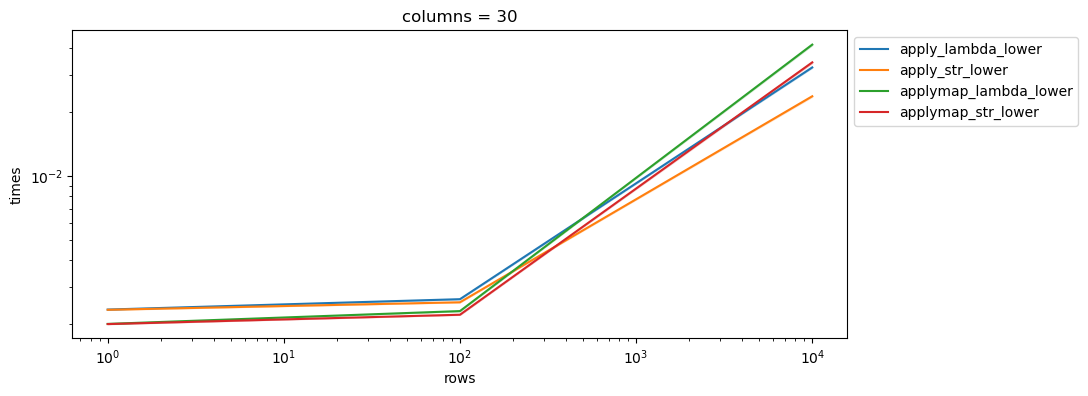

In [71]:
trends2 = {}
variables = [
    'rows',
    'columns', 
]
x = 'rows'
y = 'columns'
for gp, gdf in times_df[~times_df.function.isin(['np_vectorize_lambda_lower','entrywise_lower'])].groupby([y]):
    trends2[gp] = plt.figure(figsize = [10,4])
    sns.lineplot(
        data = gdf,
        x = x,
        y = 'times',
        hue = 'function'
    )
    plt.title('{} = {}'.format(y, gp))
    plt.yscale('log')
    plt.xscale('log')

    plt.legend(loc = 'upper left', bbox_to_anchor = [1, 1])
    plt.show()

with few columns and 1M rows we see a persistent picture: str.lower method is faster than the lambda with ''.lower() method and apply is faster than applymap method, but as we go towards more columns we see that apply that trends still holds but the apply lambda becomes better than applymap str method. Unfortunately, this observed trend is based on very few data points, we cannot really extrapolate here! Unfortunately, I ran out of patience and didn't run it for a more refined grid than what you see below

# refining the simulation

- the number of the columns makes a big difference, after all some of our methods are just simply looping over them.
- But length of the strings doesn't seem like to matter much, as long as it is not 1-2 characers.

To get a better sence, we will run it with more choices for rows and a few choices for columns:

In [31]:
# functions = [
#     'apply_lambda_lower',
#     'apply_str_lower',
#     'applymap_lambda_lower',
#     'applymap_str_lower',
#     'np_vectorize_lambda_lower',
#     'entrywise_lower',    
# ]
# str_lens = [16]
# rows = [1, 3, 10, 100, 1000, 10000,]
# columns = [1, 10]
# repeats = [1000]
# times_df = pd.DataFrame()
# for row, col, str_len, repeat in product(rows, columns, str_lens, repeats):
#     print(row, col, str_len, repeat, '\r', end = "")
#     df = df = random_str_df(
#         str_len = str_len,
#         df_shape = (row, col)
#     )
#     for fun in functions:
#         times = timeit.repeat(
#             stmt = fun + '(df)',
#             setup = 'gc.enable()',
#             number = 1,
#             repeat = repeat,
#             globals = globals()
#         )
#         tdf = pd.DataFrame({
#             'function': fun,
#             'rows': row, 
#             'columns': col, 
#             'str_len': str_len,
#             'repeat': repeat,
#             'times': times, 
#         })
#         times_df = times_df.append(tdf, ignore_index = True)
#         times_df.to_csv('times_2.csv', index = False)

In [77]:
times_df2 = pd.read_csv('times_2.csv')

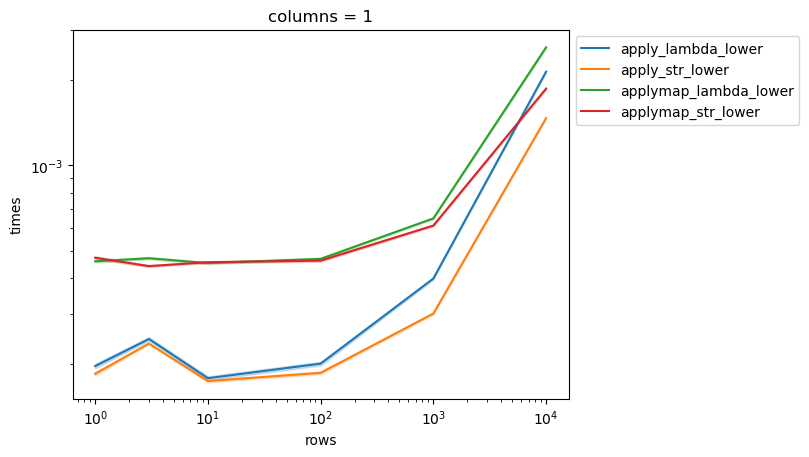

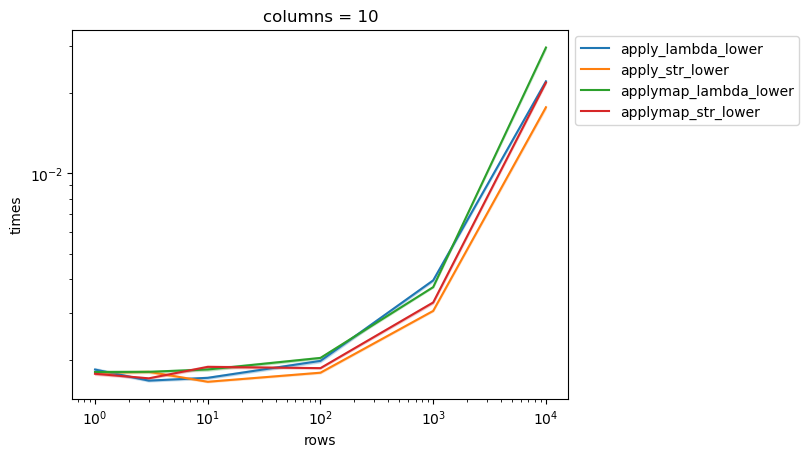

In [78]:
variables = [
    'rows',
    'columns', 
]
x = 'rows'
y = 'columns'
for gp, gdf in times_df2[~times_df2.function.isin(['np_vectorize_lambda_lower','entrywise_lower'])].groupby([y]):
    sns.lineplot(
        data = gdf,
        x = x,
        y = 'times',
        hue = 'function'
    )
    plt.title('{} = {}'.format(y, gp))
    plt.yscale('log')
    plt.xscale('log')

    plt.legend(loc = 'upper left', bbox_to_anchor = [1, 1])
    plt.show()